In [4]:
install.packages("tidyverse")

package 'tidyverse' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\yamph\AppData\Local\Temp\Rtmp6ZACrS\downloaded_packages


In [265]:
install.packages("ggcorrplot")

package 'ggcorrplot' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\yamph\AppData\Local\Temp\Rtmp6ZACrS\downloaded_packages


In [272]:
# Importing necessary libraries
library(tidyverse)
library(ggplot2)
library(ggrepel)
library(ggcorrplot)
library(DT)
library(ggpubr)
library(knitr)
library(cluster)
library(factoextra)
library(seriation)

# Dataset : COVID-19_cases_plus_census (updated)

In [220]:
dataset_plus_census <- read.csv("https://raw.githubusercontent.com/yamphurai/Project2_ClusterAnalysis/refs/heads/main/updated_COVID-19_cases_plus_census.csv")

In [221]:
#filter the dataset by Texas
dataset_plus_census <- dataset_plus_census %>% filter(state == "TX")


# Filter out the major counties (DFW, Austin, San Antonio and Houston)
counties_to_exclude <- c(
  "Dallas County", "Tarrant County", "Collin County", "Denton County", "Ellis County",
  "Johnson County", "Kaufman County", "Parker County", "Rockwall County", "Wise County",
  "Hood County", "Travis County", "Williamson County", "Hays County", "Bastrop County",
  "Caldwell County", "Bexar County", "Comal County", "Guadalupe County", "Wilson County",
  "Medina County", "Kendall County", "Bandera County", "Atascosa County", "Harris County",
  "Fort Bend County", "Montgomery County", "Brazoria County", "Galveston County", "Liberty County",
  "Waller County", "Chambers County"
)

# filter the dataset
dataset_plus_census <- dataset_plus_census %>%
  filter(!(county_name %in% counties_to_exclude))

In [222]:
# First 10 rows
head(dataset_plus_census)

,state,state_fips_code,county_name,confirmed_cases,deaths,total_pop,male_pop,female_pop,white_pop,black_pop,⋯,male_21_49,male_50_above,female_0_20,female_21_49,female_50_above,unemployed_pop,employed_pop,commute,worked_at_home,walked_to_work
,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,TX,48,Hansford County,673,17,5532,2760,2772,2950,4,⋯,1052,922,858,1053,979,94,2394,4384,18,70
2,TX,48,Stonewall County,134,4,1084,555,529,787,38,⋯,113,325,129,112,306,11,442,836,7,0
3,TX,48,Cochran County,216,12,2932,1492,1440,1104,77,⋯,418,536,420,538,548,103,1189,2274,23,12
4,TX,48,Crockett County,472,13,3836,1903,1933,1264,35,⋯,512,748,584,662,738,43,1733,3346,60,0
5,TX,48,McCulloch County,467,12,8145,4171,3974,5067,161,⋯,1354,1765,911,1334,1885,122,3658,6566,61,104
6,TX,48,Sherman County,118,11,3067,1590,1477,1712,8,⋯,582,594,398,577,555,24,1604,2930,38,72


In [223]:
# Checking for missing values
sum(is.na(dataset_plus_census))

[1] 0

In [224]:
# Basic statistics
summary(dataset_plus_census)

    state           state_fips_code county_name        confirmed_cases 
 Length:222         Min.   :48      Length:222         Min.   :     1  
 Class :character   1st Qu.:48      Class :character   1st Qu.:   436  
 Mode  :character   Median :48      Mode  :character   Median :  1077  
                    Mean   :48                         Mean   :  3619  
                    3rd Qu.:48                         3rd Qu.:  2544  
                    Max.   :48                         Max.   :107552  
     deaths          total_pop         male_pop        female_pop    
 Min.   :   0.00   Min.   :    74   Min.   :    39   Min.   :    35  
 1st Qu.:  12.00   1st Qu.:  5790   1st Qu.:  2894   1st Qu.:  2700  
 Median :  25.50   Median : 14448   Median :  7355   Median :  6766  
 Mean   :  77.73   Mean   : 42474   Mean   : 21230   Mean   : 21243  
 3rd Qu.:  61.75   3rd Qu.: 34990   3rd Qu.: 17795   3rd Qu.: 17256  
 Max.   :2018.00   Max.   :839539   Max.   :410383   Max.   :429156  
   whi

In [225]:
length(unique(dataset_plus_census$county_name))

[1] 222

Altogether there are 32 counties that are part of these 4 major cities. Previously we had 254 counties and now we have 222 counties. 

## Scale the data

In [226]:
# Prepare data
dataset_cases_TX_clustering <- dataset_plus_census %>%
  select(county_name, confirmed_cases)

In [227]:
# internal structure of the dataset
str (dataset_plus_census)

'data.frame':	222 obs. of  33 variables:
 $ state                : chr  "TX" "TX" "TX" "TX" ...
 $ state_fips_code      : int  48 48 48 48 48 48 48 48 48 48 ...
 $ county_name          : chr  "Hansford County" "Stonewall County" "Cochran County" "Crockett County" ...
 $ confirmed_cases      : int  673 134 216 472 467 118 11 114 1475 176 ...
 $ deaths               : int  17 4 12 13 12 11 0 3 46 7 ...
 $ total_pop            : int  5532 1084 2932 3836 8145 3067 289 1591 12755 1498 ...
 $ male_pop             : int  2760 555 1492 1903 4171 1590 150 796 6753 758 ...
 $ female_pop           : int  2772 529 1440 1933 3974 1477 139 795 6002 740 ...
 $ white_pop            : int  2950 787 1104 1264 5067 1712 212 964 5203 803 ...
 $ black_pop            : int  4 38 77 35 161 8 0 27 592 153 ...
 $ asian_pop            : int  0 0 0 0 0 0 0 0 0 0 ...
 $ hispanic_pop         : int  2569 246 1672 2537 2571 1327 77 513 6858 490 ...
 $ amerindian_pop       : int  6 0 6 0 1 7 0 0 31 5 ...
 $ other_rac

In [228]:
# Remove county from county names and convert them to lower case
dataset_cases_TX_clustering <- dataset_cases_TX_clustering %>% 
    mutate(county_name = tolower(gsub(" County", "", county_name)))

length(unique(dataset_cases_TX_clustering$county_name))

[1] 222

## Chosen Variables

We looked at all of the 31 feature variables that could be correlated to confirmed cases or deaths in project 1. Based on the observations made, following were the variables that seem to be highly correlated with confirmed cases.
- Race
- Income range
- Age group

Therefore, these variables are chosen to peform various types of cluster analysis.

In [229]:
# Basic statistics of the chosen variables
summary(dataset_plus_census %>% select(white_pop, black_pop, asian_pop, hispanic_pop, amerindian_pop, other_race_pop,
                                  income_less_50K, income_50K_100K, income_100K_150K, income_150K_more,
                                  male_0_20, male_21_49, male_50_above, female_0_20, female_21_49, female_50_above))

   white_pop        black_pop          asian_pop        hispanic_pop   
 Min.   :    55   Min.   :    0.00   Min.   :    0.0   Min.   :    12  
 1st Qu.:  2580   1st Qu.:   55.25   1st Qu.:    6.0   1st Qu.:  1468  
 Median :  7632   Median :  482.50   Median :   45.0   Median :  3700  
 Mean   : 18563   Mean   : 3292.94   Mean   :  556.8   Mean   : 19338  
 3rd Qu.: 18465   3rd Qu.: 2673.00   3rd Qu.:  241.8   3rd Qu.:  9827  
 Max.   :162449   Max.   :85901.00   Max.   :12857.0   Max.   :770794  
 amerindian_pop   other_race_pop   income_less_50K  income_50K_100K  
 Min.   :   0.0   Min.   :  0.00   Min.   :     9   Min.   :   19.0  
 1st Qu.:   5.0   1st Qu.:  0.00   1st Qu.:  1111   1st Qu.:  534.8  
 Median :  30.5   Median :  0.00   Median :  2740   Median : 1427.5  
 Mean   : 125.9   Mean   : 31.38   Mean   :  7589   Mean   : 4176.5  
 3rd Qu.: 113.5   3rd Qu.: 26.75   3rd Qu.:  6524   3rd Qu.: 3627.0  
 Max.   :2344.0   Max.   :477.00   Max.   :148982   Max.   :74071.0  
 incom

## K-means (Euclidean distance) for variables related to Race + Income ranges

### Clustering Tendency (Hopkins Statistic)

In [16]:
# Installing hopkins package
install.packages("hopkins")

package 'hopkins' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\yamph\AppData\Local\Temp\Rtmp6ZACrS\downloaded_packages


In [17]:
library(hopkins)

In [230]:
# Prepare the dataset with columns related to income ranges and races
dataset_plus_census_race_income <- dataset_plus_census %>% 
  select(white_pop, black_pop, asian_pop, hispanic_pop, amerindian_pop, other_race_pop, income_less_50K, income_50K_100K, income_100K_150K, income_150K_more) %>% 
  scale() %>% as_tibble()

# Scale the dataset
dataset_plus_census_scaled_race_income <- scale(dataset_plus_census_race_income)

In [231]:
summary(dataset_plus_census_scaled_race_income)

   white_pop           black_pop          asian_pop        hispanic_pop    
 Min.   :-0.642387   Min.   :-0.36496   Min.   :-0.3314   Min.   :-0.2510  
 1st Qu.:-0.554748   1st Qu.:-0.35884   1st Qu.:-0.3278   1st Qu.:-0.2321  
 Median :-0.379400   Median :-0.31149   Median :-0.3046   Median :-0.2031  
 Mean   : 0.000000   Mean   : 0.00000   Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.:-0.003394   3rd Qu.:-0.06871   3rd Qu.:-0.1875   3rd Qu.:-0.1235  
 Max.   : 4.994073   Max.   : 9.15558   Max.   : 7.3199   Max.   : 9.7590  
 amerindian_pop     other_race_pop     income_less_50K    income_50K_100K   
 Min.   :-0.47791   Min.   :-0.43877   Min.   :-0.44296   Min.   :-0.48025  
 1st Qu.:-0.45894   1st Qu.:-0.43877   1st Qu.:-0.37855   1st Qu.:-0.42067  
 Median :-0.36216   Median :-0.43877   Median :-0.28334   Median :-0.31755  
 Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.00000  
 3rd Qu.:-0.04717   3rd Qu.:-0.06472   3rd Qu.:-0.06225   3rd Qu.:-0.06348  
 Max. 

Ranges of all feature columns are somewhat same indicating the these columns have been scaled.

In [232]:
head(dataset_plus_census_scaled_race_income)

white_pop,black_pop,asian_pop,hispanic_pop,amerindian_pop,other_race_pop,income_less_50K,income_50K_100K,income_100K_150K,income_150K_more
-0.5419058,-0.3645185,-0.3313628,-0.2177805,-0.4551422,-0.4387658,-0.3755826,-0.4293063,-0.4401619,-0.4148059
-0.6169804,-0.3607502,-0.3313628,-0.2479489,-0.4779130,-0.4387658,-0.4295798,-0.4678877,-0.4769018,-0.4570645
-0.6059778,-0.3564278,-0.3313628,-0.2294297,-0.4551422,-0.4387658,-0.4082498,-0.4543727,-0.4641491,-0.4483214
-0.6004244,-0.3610827,-0.3313628,-0.2181961,-0.4779130,-0.4387658,-0.4047435,-0.4308079,-0.4189074,-0.4492928
-0.4684278,-0.3471179,-0.3313628,-0.2177546,-0.4741178,2.3858128,-0.3420974,-0.3700479,-0.4043329,-0.4075199
-0.5848750,-0.3640752,-0.3313628,-0.2339102,-0.4513470,-0.4387658,-0.4152040,-0.4430524,-0.4447164,-0.4386068


In [233]:
# Compute the Hopkins statistic
set.seed(123) 
hopkins_stat <- hopkins(dataset_plus_census_scaled_race_income)
hopkins_stat

[1] 1

This shows that there is a strong clustering tendency.

### Average Silhouette Width

In [22]:
install.packages("factoextra")
library(cluster)
library(factoextra)

package 'factoextra' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\yamph\AppData\Local\Temp\Rtmp6ZACrS\downloaded_packages


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



[1] 2


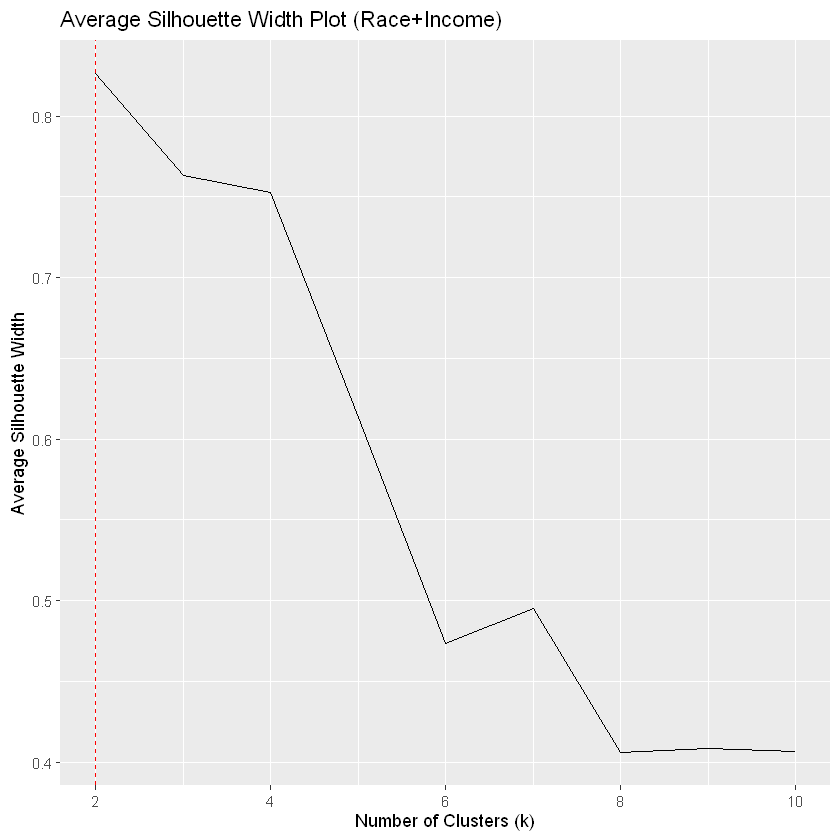

In [234]:
# range for number of clusters
ks_race_income <- 2:10

# distance
d_race_income <- dist(dataset_plus_census_scaled_race_income)

# Average Silhouette Width
ASW_race_income <- sapply(ks_race_income, FUN=function(k) {
  kmeans_result <- kmeans(dataset_plus_census_scaled_race_income, centers = k, nstart = 10)
  silhouette_info <- silhouette(kmeans_result$cluster, d_race_income)
  mean(silhouette_info[, 3])  # Return the average silhouette width
})

# best k
best_k_race_income <- ks_race_income[which.max(ASW_race_income)]
print(best_k_race_income)

# Plot the Average Silhouette Width
ggplot(data.frame(ks_race_income, ASW_race_income), aes(x = ks_race_income, y = ASW_race_income)) + 
  geom_line() +
  geom_vline(xintercept = best_k_race_income, color = "red", linetype = 2) + 
  ggtitle("Average Silhouette Width Plot (Race+Income)") +
  xlab("Number of Clusters (k)") +
  ylab("Average Silhouette Width")

  cluster size ave.sil.width
1       1   16          0.13
2       2  206          0.88
  cluster size ave.sil.width
1       1    2          0.38
2       2  196          0.83
3       3   17          0.16
4       4    7          0.25
  cluster size ave.sil.width
1       1    2          0.31
2       2   33          0.17
3       3    2          0.38
4       4    7          0.20
5       5  166          0.70
6       6   12          0.06
  cluster size ave.sil.width
1       1   21          0.08
2       2    8          0.16
3       3  122          0.66
4       4    7          0.16
5       5    2          0.31
6       6    2          0.31
7       7   58          0.07
8       8    2          0.07


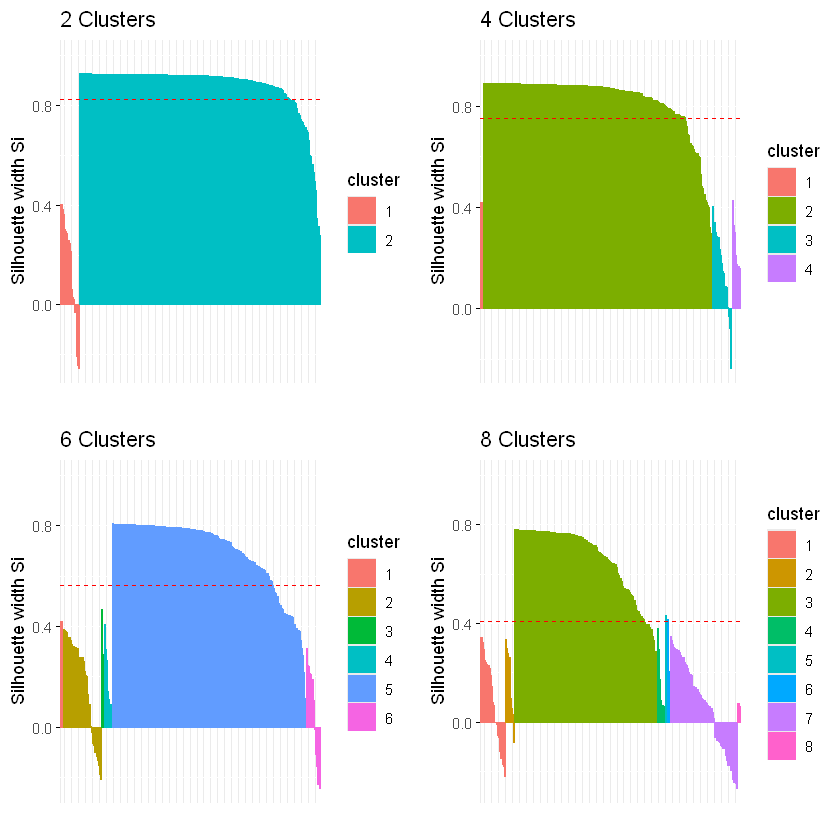

In [236]:
# K-means clustering (10 random restarts)
k_means_race_income_first <- kmeans(dataset_plus_census_scaled_race_income, centers=2, nstart = 10)
k_means_race_income_second <- kmeans(dataset_plus_census_scaled_race_income, centers=4, nstart = 10)
k_means_race_income_third <- kmeans(dataset_plus_census_scaled_race_income, centers=6, nstart = 10)
k_means_race_income_fourth <- kmeans(dataset_plus_census_scaled_race_income, centers=8, nstart = 10)

# Compute silhouette scores
sil_race_income_first <- silhouette(k_means_race_income_first$cluster, d_race_income)
sil_race_income_second <- silhouette(k_means_race_income_second$cluster, d_race_income)
sil_race_income_third <- silhouette(k_means_race_income_third$cluster, d_race_income)
sil_race_income_fourth <- silhouette(k_means_race_income_fourth$cluster, d_race_income)

# Arrange the plots side by side in a 2x2 grid
sil_race_income_first <- silhouette(k_means_race_income_first$cluster, d_race_income)
sil_race_income_second <- silhouette(k_means_race_income_second$cluster, d_race_income)
sil_race_income_third <- silhouette(k_means_race_income_third$cluster, d_race_income)
sil_race_income_fourth <- silhouette(k_means_race_income_fourth$cluster, d_race_income)

# Visualize silhouette plots
p1 <- fviz_silhouette(sil_race_income_first) + ggtitle("2 Clusters")
p2 <- fviz_silhouette(sil_race_income_second) + ggtitle("4 Clusters")
p3 <- fviz_silhouette(sil_race_income_third) + ggtitle("6 Clusters")
p4 <- fviz_silhouette(sil_race_income_fourth) + ggtitle("8 Clusters")

# Arrange the plots side by side in a 2x2 grid (note the empty space)
combined_silplot_race_income <- ggarrange(p1, p2, p3, p4, ncol = 2, nrow = 2)

# Display the combined plot
print(combined_silplot_race_income)

Based on the above two plots, we can see that the average silhouette widht is highest when there are only 2 clusters. The value decreases with more number of clusters.

### Elbow Method: Within-Cluster Sum of Square

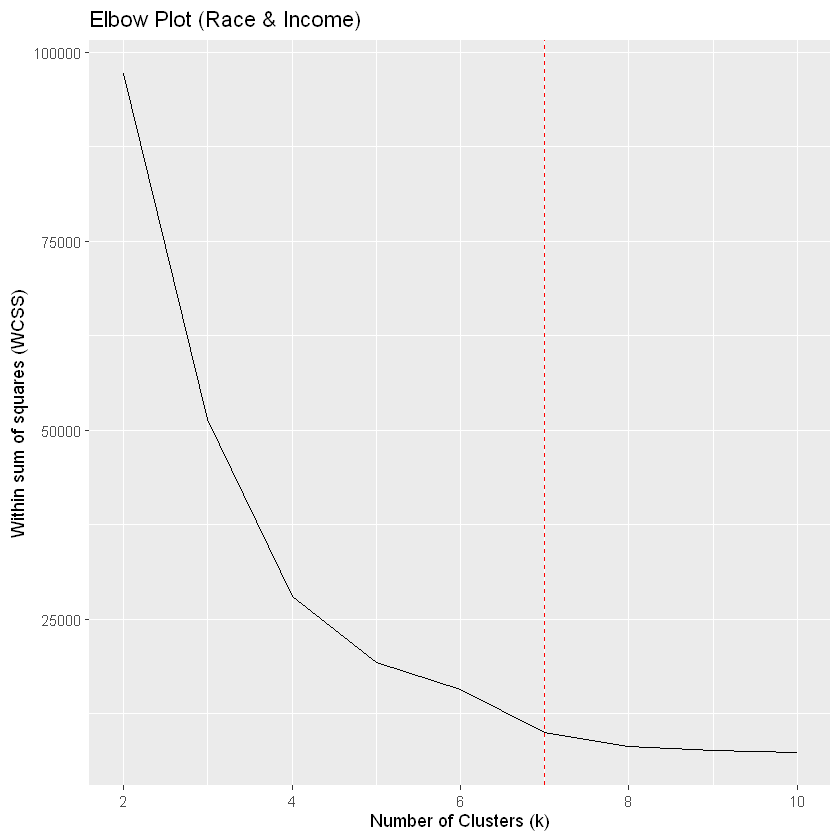

In [238]:
# use the same range of K 
#set.seed(1234)

#Calculate within-cluster sum of squares for number of clusters
WCSS_race_income <- sapply(ks_race_income, FUN = function(k) {
  kmeans(d_race_income <- dist(dataset_plus_census_scaled_race_income), centers = k, nstart = 10)$tot.withinss
  })

# Plot 
ggplot(tibble(ks_race_income, WCSS_race_income), aes(ks_race_income, WCSS_race_income)) + 
  geom_line() +
  geom_vline(xintercept = 7, color = "red", linetype = 2)+
  ggtitle("Elbow Plot (Race & Income)") +
  xlab("Number of Clusters (k)") +
  ylab("Within sum of squares (WCSS)")

This indicates that after about 7 clusters, the within sum of squares does not seem to decrease significantly.

### Gap Statistic

Clustering Gap statistic ["clusGap"] from call:
clusGap(x = dataset_plus_census_scaled_race_income, FUNcluster = kmeans, K.max = 10, nstart = 10)
B=100 simulated reference sets, k = 1..10; spaceH0="scaledPCA"
 --> Number of clusters (method 'firstSEmax', SE.factor=1): 6
          logW   E.logW      gap     SE.sim
 [1,] 4.908883 6.399682 1.490799 0.01729303
 [2,] 4.521293 6.134254 1.612961 0.01617139
 [3,] 4.364247 6.026261 1.662014 0.01510208
 [4,] 4.254925 5.935977 1.681053 0.01557274
 [5,] 4.108136 5.868729 1.760592 0.01407752
 [6,] 4.026812 5.816780 1.789968 0.01375097
 [7,] 3.994441 5.777251 1.782810 0.01294541
 [8,] 3.893139 5.742676 1.849537 0.01271991
 [9,] 3.851386 5.711586 1.860199 0.01221750
[10,] 3.822598 5.682707 1.860108 0.01204762

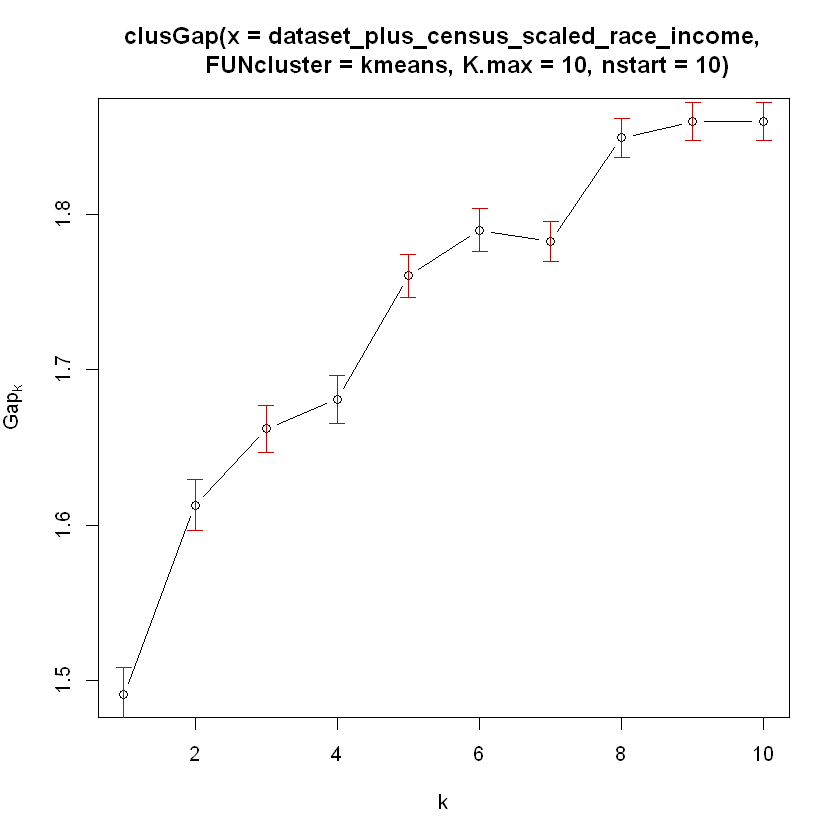

In [239]:
k_race_gap_income <- clusGap(dataset_plus_census_scaled_race_income, 
             FUN = kmeans,  
             nstart = 10, 
             K.max = 10)
k_race_gap_income

plot(k_race_gap_income)

Overall we see that silhouette and gap statistic methods suggest we just need 2 clusters for the dataset.

### Compare clusterings (unsupervised)

In [161]:
library(cluster)

In [240]:
# k-means clustering with different numbers of clusters
k_means_race_income_first <- kmeans(dataset_plus_census_scaled_race_income, centers = 2)
k_means_race_income_second <- kmeans(dataset_plus_census_scaled_race_income, centers = 4)
k_means_race_income_third <- kmeans(dataset_plus_census_scaled_race_income, centers = 8)
k_means_race_income_fourth <- kmeans(dataset_plus_census_scaled_race_income, centers = 10)

# Compute clustering statistics for each clustering result
cluster_stats <- sapply(
  list(
    km_first = k_means_race_income_first$cluster,
    km_second = k_means_race_income_second$cluster,
    km_third = k_means_race_income_third$cluster,
    km_fourth = k_means_race_income_fourth$cluster
  ),
  FUN = function(x) fpc::cluster.stats(d_race_income, x)
)

# Extract the desired statistics
race_income_cluster_stats <- cluster_stats[c("within.cluster.ss", "avg.silwidth", "pearsongamma", "dunn"), ]

# Print the results
print(race_income_cluster_stats)

                  km_first  km_second km_third   km_fourth
within.cluster.ss 939.1497  436.7534  287.3531   277.3732 
avg.silwidth      0.8260791 0.7528466 0.3968105  0.2972571
pearsongamma      0.8368706 0.7924121 0.407337   0.301155 
dunn              0.1224606 0.1325623 0.01952547 0.0100413


Looking at the sum of squares, we see that the value starts to decrease not so sifnificantly after 8 clusters supporting the observation made on elbow method.  
Looking at the average silwidth values, we can see that it's max at two (but 3 is reasonable too) clusters supporting the observation made on the silwidth plot.  
The pearson gamma values also indicate that we just need two clusters (3 is reasonable too) for this dataset since this value is highest for clusters. This values does not improve much (does not decrease) with more clusters added.  
But the dunn index indicates that we need three clusters for this dataset since it has the highest value for 3 clusters. The value does not improve (does not decrease) with  more clusters added. 
Overall, these values indicate that adding more clusters might lead to more compact clusters but less defined and well-separated clusters. Therefore, 3 clusters could offer the most robust clustering for the dataset.

### Inspect the clusters (Visualization)

Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse


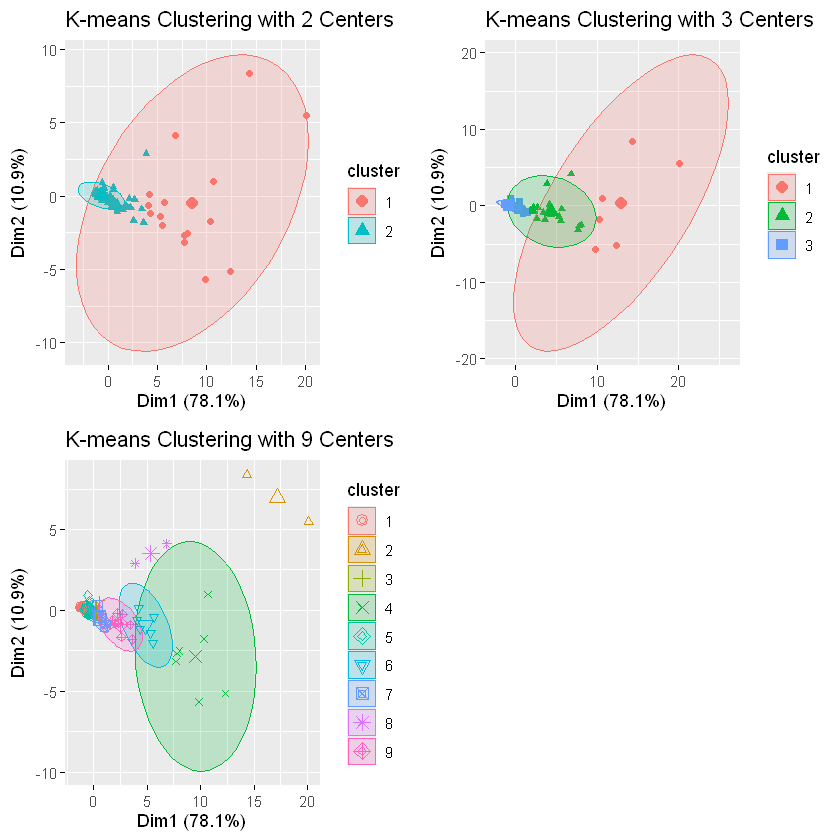

In [241]:
# K-means clustering with 3 clusters
kmeans_race_income_first <- kmeans(dataset_plus_census_scaled_race_income, centers = 2)
plot_kmeans_race_income_first <- fviz_cluster(kmeans_race_income_first, data = dataset_plus_census_scaled_race_income,
                              centroids = TRUE, geom = "point", ellipse.type = "norm") +
  labs(title = "K-means Clustering with 2 Centers")

# K-means clustering with 3 clusters
kmeans_race_income_second <- kmeans(dataset_plus_census_scaled_race_income, centers = 3)
plot_kmeans_race_income_second <- fviz_cluster(kmeans_race_income_second, data = dataset_plus_census_scaled_race_income,
                              centroids = TRUE, geom = "point", ellipse.type = "norm") +
  labs(title = "K-means Clustering with 3 Centers")

# K-means clustering with 9 clusters
kmeans_race_income_third <- kmeans(dataset_plus_census_scaled_race_income, centers = 9)
plot_kmeans_race_income_third <- fviz_cluster(kmeans_race_income_third, data = dataset_plus_census_scaled_race_income,
                              centroids = TRUE, geom = "point", ellipse.type = "norm") +
  labs(title = "K-means Clustering with 9 Centers")

# Arrange the plots side by side in a 2x2 grid
combined_plot_race_income <- ggarrange(plot_kmeans_race_income_first, plot_kmeans_race_income_second, plot_kmeans_race_income_third, ncol = 2, nrow = 2)

# Display the combined plot
print(combined_plot_race_income)

#Save the plot
ggsave("combined_plot_race_income.png", plot = combined_plot_race_income, width = 6, height = 3)

Comparing three clusterings with varying number of clusters, we can clearly see that we just need two clusters for our dataset. Even having one more cluster (three total), the third cluster picks up an datapoints that could be part of cluster 2. That means, if we use more clusters, more outliers will be clustered as a separate cluster. So visually, we can say that we just need two clusters for the dataset.

In [246]:
# Adjust the k value for further inspection of the clusters
k_means_race_income <- kmeans(dataset_plus_census_scaled_race_income, centers=2, nstart = 10)

cluster_profile_race_income <- ggplot(pivot_longer(as_tibble(k_means_race_income$centers,  rownames = "cluster"), 
  cols = colnames(k_means_race_income$centers)), 
  aes(y = name, x = value, fill = cluster)) +
  geom_bar(stat = "identity") +
  facet_grid(cols = vars(cluster)) +
  labs(y = "feature", x = "z-scores", title = "Cluster Profiles (Race & Income)") + 
  guides(fill="none")

#Save teh profile
ggsave("cluster_profile_race_income.png", plot = cluster_profile_race_income, width = 6, height = 2)

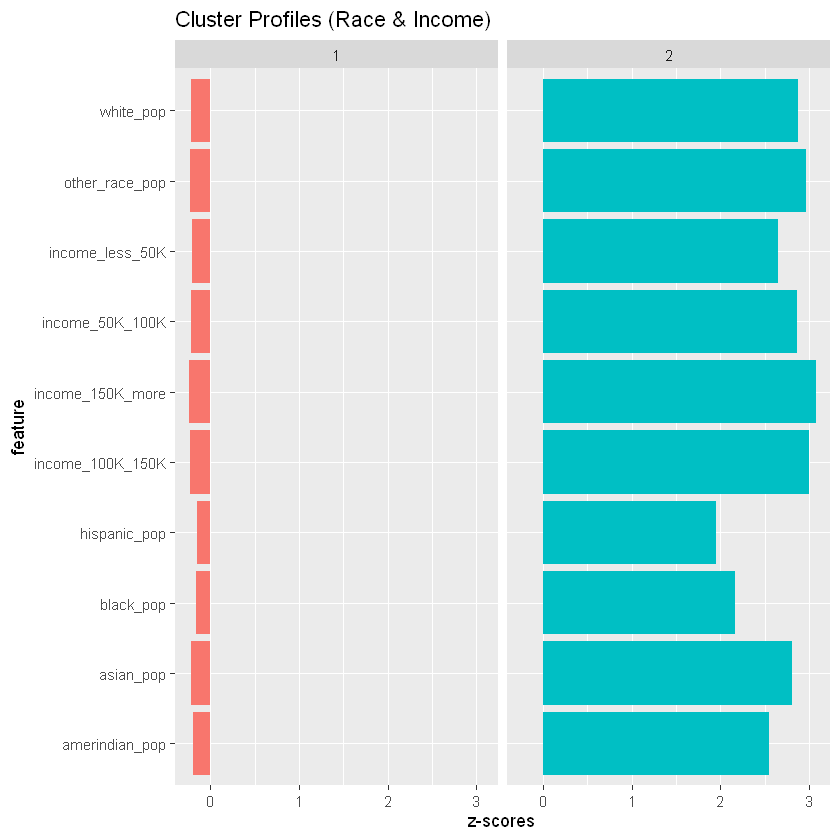

In [247]:
cluster_profile_race_income

I started with 4 clusters and visually analyzed the disributions among all the features. One of 4 clusters showed very similar distribution for all features indicatin that this cluster lacks meaningful information (does not decribe much of the variation). Then I decrease the number of clusters to 3 and performed same analysis. I got the same result. Finally, I ended up having only 2 clusters that was enough to represent the variation in the data.\
    Increasing the number of clusters did not result in better differentiation and instead led to clusters that exhibited identical or near-identical values across features

In [248]:
k_means_race_income

K-means clustering with 2 clusters of sizes 206, 16

Cluster means:
   white_pop  black_pop  asian_pop hispanic_pop amerindian_pop other_race_pop
1 -0.2238753 -0.1681191 -0.2183538   -0.1513248     -0.1981602     -0.2301738
2  2.8823938  2.1645328  2.8113049    1.9483070      2.5513130      2.9634881
  income_less_50K income_50K_100K income_100K_150K income_150K_more
1      -0.2057027      -0.2229729       -0.2330015       -0.2389475
2       2.6484217       2.8707758        2.9998942        3.0764496

Clustering vector:
  [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [75] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[112] 1 2 2 1 1 2 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 2 2 1 1 1
[149] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1
[186] 1 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 

 The ratio of between_SS to total_SS is about 57%, suggesting that the clustering structure explains a significant portion of the variability in the data.  
Given that the first cluster has distinctly different characteristics compared to the second and that we see a clear separation in terms of average feature values, it is reasonable to conclude that two clusters are sufficient to define the dataset.

### Heat map

In [138]:
# load the dataset
dataset_plus_census_heatmap <- read.csv("https://raw.githubusercontent.com/yamphurai/Project2_ClusterAnalysis/refs/heads/main/updated_COVID-19_cases_plus_census.csv")

In [139]:
dataset_plus_census_heatmap <- dataset_plus_census_heatmap %>% mutate(across(where(is.character), factor))

In [140]:
# Filter by Texas
dataset_plus_census_heatmap <- dataset_plus_census_heatmap %>% filter(state == "TX")

In [141]:
# Filter out the major counties (DFW, Austin, San Antonio and Houston)

counties_to_exclude <- c(
  "Dallas County", "Tarrant County", "Collin County", "Denton County", "Ellis County",
  "Johnson County", "Kaufman County", "Parker County", "Rockwall County", "Wise County",
  "Hood County", "Travis County", "Williamson County", "Hays County", "Bastrop County",
  "Caldwell County", "Bexar County", "Comal County", "Guadalupe County", "Wilson County",
  "Medina County", "Kendall County", "Bandera County", "Atascosa County", "Harris County",
  "Fort Bend County", "Montgomery County", "Brazoria County", "Galveston County", "Liberty County",
  "Waller County", "Chambers County"
)

# filter the dataset
dataset_plus_census_heatmap <- dataset_plus_census_heatmap %>%
  filter(!(county_name %in% counties_to_exclude))

In [142]:
# select the features
dataset_plus_census_heatmap <- dataset_plus_census_heatmap %>%  
  select(county_name, confirmed_cases, deaths, total_pop, white_pop, black_pop, asian_pop, hispanic_pop, amerindian_pop, amerindian_pop, other_race_pop, income_less_50K, 
         income_50K_100K, income_100K_150K, income_150K_more)

In [143]:
length(unique(dataset_plus_census_heatmap$county_name))

[1] 222

Altogether there are 32 counties that are part of these 4 major cities. Previously we had 254 counties and now we have 222 counties. 

In [144]:
# per 1000
dataset_plus_census_heatmap <- dataset_plus_census_heatmap %>% mutate(
  cases_per_1000 = confirmed_cases/total_pop*1000, 
  deaths_per_1000 = deaths/total_pop*1000, 
  death_per_case = deaths/confirmed_cases)


In [145]:
# extract the polygan data
counties_polygon <- as_tibble(map_data("county"))
counties_polygon_TX <- counties_polygon %>% dplyr::filter(region == "texas") %>% 
  rename(c(county = subregion)) 

In [146]:
#checking the counties on the polygon dataset
length(unique(counties_polygon_TX$county))

[1] 254

In [147]:
# remove "County" from the names and convert thme to lowercase
counties_to_exclude <- tolower(gsub(" County", "", counties_to_exclude))

# filter the dataset to match with our dataset for joining purpose
counties_polygon_TX <- counties_polygon_TX %>%
  filter(!(county %in% counties_to_exclude))

In [148]:
length(unique(counties_polygon_TX$county))

[1] 222

We are good to preceed.

In [149]:
# remove County from the names and convert them to lowercase
dataset_plus_census_heatmap <- dataset_plus_census_heatmap %>% mutate(county = county_name %>% 
    str_to_lower() %>% str_replace('\\s+county\\s*$', ''))

In [133]:
# Database join
counties_polygon_TX <- right_join(counties_polygon_TX, dataset_plus_census_heatmap)

Joining with `by = join_by(county)`


In [134]:
head(counties_polygon_TX)

long,lat,group,order,region,county,county_name,confirmed_cases,deaths,total_pop,⋯,hispanic_pop,amerindian_pop,other_race_pop,income_less_50K,income_50K_100K,income_100K_150K,income_150K_more,cases_per_1000,deaths_per_1000,death_per_case
<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<fct>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
-95.75271,31.53560,2492,74520,texas,anderson,Anderson County,5575,75,57747,⋯,9981,160,11,9357,4937,1499,774,96.54181,1.298769,0.01345291
-95.76989,31.55852,2492,74521,texas,anderson,Anderson County,5575,75,57747,⋯,9981,160,11,9357,4937,1499,774,96.54181,1.298769,0.01345291
-95.76416,31.58143,2492,74522,texas,anderson,Anderson County,5575,75,57747,⋯,9981,160,11,9357,4937,1499,774,96.54181,1.298769,0.01345291
-95.72979,31.58143,2492,74523,texas,anderson,Anderson County,5575,75,57747,⋯,9981,160,11,9357,4937,1499,774,96.54181,1.298769,0.01345291
-95.74698,31.61008,2492,74524,texas,anderson,Anderson County,5575,75,57747,⋯,9981,160,11,9357,4937,1499,774,96.54181,1.298769,0.01345291
-95.72405,31.63873,2492,74525,texas,anderson,Anderson County,5575,75,57747,⋯,9981,160,11,9357,4937,1499,774,96.54181,1.298769,0.01345291


In [150]:
# Scaling
dataset_plus_census_heatmap_scaled <- dataset_plus_census_heatmap %>% 
  select(white_pop, black_pop, asian_pop, hispanic_pop, amerindian_pop, amerindian_pop, other_race_pop, income_less_50K, income_50K_100K, income_100K_150K, income_150K_more) %>% 
  scale() %>% as_tibble()

# k means setting
km_race_income_heatmap <- kmeans(dataset_plus_census_heatmap_scaled, centers = 2, nstart = 10)

In [151]:
# Add the cluster labels to the dataset
dataset_plus_census_clust_heatmap <- dataset_plus_census_heatmap %>% 
    add_column(cluster = factor(km_race_income_heatmap$cluster))

In [152]:
head(dataset_plus_census_clust_heatmap)

,county_name,confirmed_cases,deaths,total_pop,white_pop,black_pop,asian_pop,hispanic_pop,amerindian_pop,other_race_pop,income_less_50K,income_50K_100K,income_100K_150K,income_150K_more,cases_per_1000,deaths_per_1000,death_per_case,county,cluster
,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
1,Hansford County,673,17,5532,2950,4,0,2569,6,0,1162,460,172,130,121.65582,3.073030,0.02526003,hansford,2
2,Stonewall County,134,4,1084,787,38,0,246,0,0,238,126,51,43,123.61624,3.690037,0.02985075,stonewall,2
3,Cochran County,216,12,2932,1104,77,0,1672,6,0,603,243,93,61,73.66985,4.092769,0.05555556,cochran,2
4,Crockett County,472,13,3836,1264,35,0,2537,0,0,663,447,242,59,123.04484,3.388947,0.02754237,crockett,2
5,McCulloch County,467,12,8145,5067,161,0,2571,1,202,1735,973,290,145,57.33579,1.473297,0.02569593,mcculloch,2
6,Sherman County,118,11,3067,1712,8,0,1327,7,0,484,341,157,81,38.47408,3.586567,0.09322034,sherman,2


In [153]:
# Database join
counties_polygon_TX_clust <- right_join(counties_polygon_TX, dataset_plus_census_clust_heatmap, 
                                        join_by(county))

In [154]:
#Final check of number of counties before plotting the heat map
length(unique(counties_polygon_TX_clust$county))

[1] 222

  [1] "anderson"      "andrews"       "angelina"      "aransas"      
  [5] "archer"        "armstrong"     "austin"        "bailey"       
  [9] "baylor"        "bee"           "blanco"        "borden"       
 [13] "bosque"        "bowie"         "brewster"      "briscoe"      
 [17] "brooks"        "brown"         "burleson"      "burnet"       
 [21] "calhoun"       "callahan"      "camp"          "carson"       
 [25] "cass"          "castro"        "cherokee"      "childress"    
 [29] "clay"          "cochran"       "coke"          "coleman"      
 [33] "collingsworth" "colorado"      "comanche"      "concho"       
 [37] "cooke"         "coryell"       "cottle"        "crane"        
 [41] "crockett"      "crosby"        "culberson"     "dallam"       
 [45] "dawson"        "deaf smith"    "delta"         "dickens"      
 [49] "dimmit"        "donley"        "duval"         "eastland"     
 [53] "edwards"       "erath"         "falls"         "fannin"       
 [57] "fayette"     

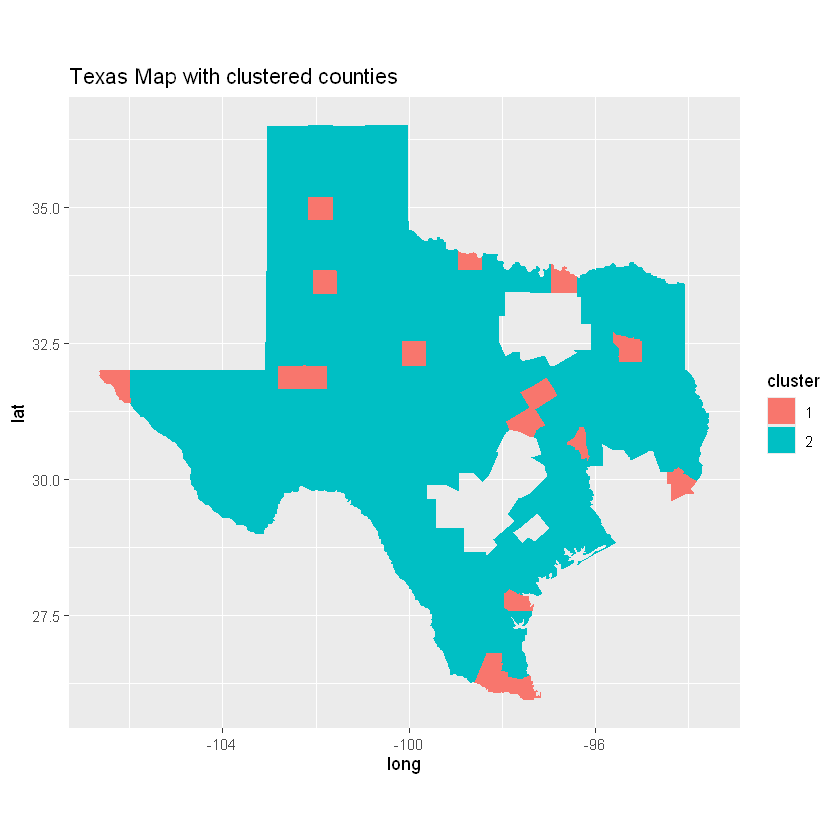

In [156]:
# heat map
ggplot(counties_polygon_TX_clust, aes(long, lat)) + 
  geom_polygon(aes(group = group, fill = cluster)) +
  coord_quickmap() + 
  labs(title = "Texas Map with clustered counties")

# Filter for counties in cluster 2
counties_cluster_2 <- counties_polygon_TX_clust %>%
  filter(cluster == 2)

# Print the counties in cluster 2
print(unique(counties_cluster_2$county))

Above are the counties that are in same clusters based on the data related to various races and income levels that had COVID cases. We can see that most of the counties that lie in a very rural areas (away from major metropolitans) fall in same cluster (i.e. cluster 2).  
The clustering might suggest that these rural counties had similar patterns in COVID-19 cases, possibly due to similar healthcare infrastructure, accessibility, and community behaviors.
Policymakers can use this clustering information to design and implement policies that are tailored to the unique needs of rural areas. This could include economic support, healthcare improvements, and educational programs. Local governments and community organizations can develop programs that address the specific social and economic challenges faced by these rural areas.

In [100]:
table(dataset_plus_census$income_category)


   low medium   high 
   147     96     11 

## K-means (Euclidean distance) for variables related to male age ranges + Race

In [252]:
# Prepare the dataset
dataset_plus_census_race_male <- dataset_plus_census %>% 
  select(white_pop, black_pop, asian_pop, hispanic_pop, amerindian_pop, other_race_pop, male_0_20, male_21_49, male_50_above) %>% 
  scale() %>% as_tibble()

# Scale the columns for K-means
dataset_plus_census_scaled_race_male <- scale(dataset_plus_census_race_male)

In [253]:
head(dataset_plus_census_scaled_race_male)

white_pop,black_pop,asian_pop,hispanic_pop,amerindian_pop,other_race_pop,male_0_20,male_21_49,male_50_above
-0.5419058,-0.3645185,-0.3313628,-0.2177805,-0.4551422,-0.4387658,-0.3433435,-0.3723423,-0.4551314
-0.6169804,-0.3607502,-0.3313628,-0.2479489,-0.4779130,-0.4387658,-0.3827586,-0.4213278,-0.5015824
-0.6059778,-0.3564278,-0.3313628,-0.2294297,-0.4551422,-0.4387658,-0.3575976,-0.4054166,-0.4851651
-0.6004244,-0.3610827,-0.3313628,-0.2181961,-0.4779130,-0.4387658,-0.3510188,-0.4005129,-0.4686699
-0.4684278,-0.3471179,-0.3313628,-0.2177546,-0.4741178,2.3858128,-0.3244151,-0.3565876,-0.3895398
-0.5848750,-0.3640752,-0.3313628,-0.2339102,-0.4513470,-0.4387658,-0.3648112,-0.3968611,-0.4806523


In [254]:
summary(dataset_plus_census_scaled_race_male)

   white_pop           black_pop          asian_pop        hispanic_pop    
 Min.   :-0.642387   Min.   :-0.36496   Min.   :-0.3314   Min.   :-0.2510  
 1st Qu.:-0.554748   1st Qu.:-0.35884   1st Qu.:-0.3278   1st Qu.:-0.2321  
 Median :-0.379400   Median :-0.31149   Median :-0.3046   Median :-0.2031  
 Mean   : 0.000000   Mean   : 0.00000   Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.:-0.003394   3rd Qu.:-0.06871   3rd Qu.:-0.1875   3rd Qu.:-0.1235  
 Max.   : 4.994073   Max.   : 9.15558   Max.   : 7.3199   Max.   : 9.7590  
 amerindian_pop     other_race_pop       male_0_20          male_21_49      
 Min.   :-0.47791   Min.   :-0.43877   Min.   :-0.39136   Min.   :-0.42670  
 1st Qu.:-0.45894   1st Qu.:-0.43877   1st Qu.:-0.34323   1st Qu.:-0.37657  
 Median :-0.36216   Median :-0.43877   Median :-0.27155   Median :-0.29161  
 Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.00000  
 3rd Qu.:-0.04717   3rd Qu.:-0.06472   3rd Qu.:-0.08719   3rd Qu.:-0.09854  
 Max. 

Mean is 0 for all columns. Min and max is similar to all columns. So scaling is good.

### Clustering Tendency (Hopkins Statistic)

In [255]:
# Compute the Hopkins statistic
set.seed(123) 
hopkins_stat_race_male<- hopkins(dataset_plus_census_scaled_race_male)
hopkins_stat_race_male

[1] 1

This shows that there is a strong clustering tendency.

### Average Silhouette Width

[1] 2


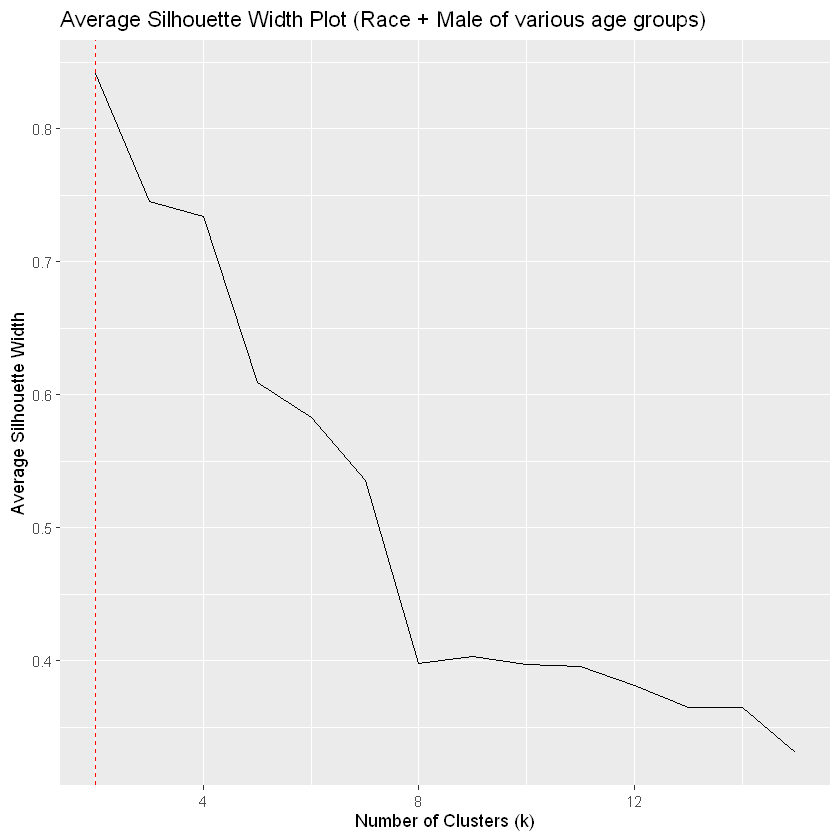

In [256]:
# range for number of clusters
ks_race_male <- 2:15

# distance
d_race_male <- dist(dataset_plus_census_scaled_race_male)

# Average Silhouette Width
ASW_race_male <- sapply(ks_race_male, FUN=function(k) {
  kmeans_result <- kmeans(dataset_plus_census_scaled_race_male, centers = k, nstart = 10)
  silhouette_info <- silhouette(kmeans_result$cluster, d_race_male)
  mean(silhouette_info[, 3])  # Return the average silhouette width
})

# best k
best_k_race_male <- ks_race_income[which.max(ASW_race_male)]
print(best_k_race_male)

# Plot the Average Silhouette Width
ggplot(data.frame(ks_race_male, ASW_race_male), aes(x = ks_race_male, y = ASW_race_male)) + 
  geom_line() +
  geom_vline(xintercept = best_k_race_male, color = "red", linetype = 2) + 
  ggtitle("Average Silhouette Width Plot (Race + Male of various age groups)") +
  xlab("Number of Clusters (k)") +
  ylab("Average Silhouette Width")

Based onthe average silhouette width analysis, two or three clusters is optimal for our dataset. The dataset has the tendency to have natural division into 2 or 3 or 4 clusters. If more clusters are added, the added clusters might split one or more of the existing clusters with internal variability or low separation from other clusters. So the data does not fit the true underlying structure well with more than 4 clusters.

  cluster size ave.sil.width
1       1   12          0.16
2       2  210          0.88
  cluster size ave.sil.width
1       1  196          0.83
2       2    7         -0.04
3       3   19          0.13
  cluster size ave.sil.width
1       1   28          0.16
2       2    7          0.18
3       3    2          0.44
4       4   10          0.00
5       5  175          0.73


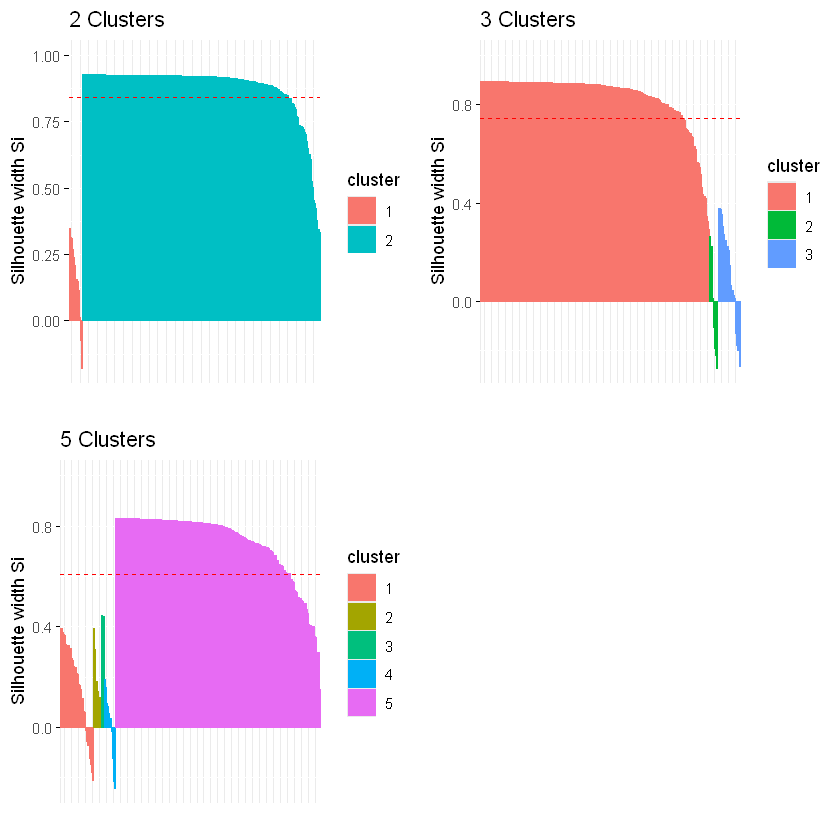

In [258]:
# K-means clustering (10 random restarts)
k_means_race_male_first <- kmeans(dataset_plus_census_scaled_race_male, centers=2, nstart = 10)
k_means_race_male_second <- kmeans(dataset_plus_census_scaled_race_male, centers=3, nstart = 10)
k_means_race_male_third <- kmeans(dataset_plus_census_scaled_race_male, centers=5, nstart = 10)

# Compute silhouette scores
sil_race_male_first <- silhouette(k_means_race_male_first$cluster, d_race_male)
sil_race_male_second <- silhouette(k_means_race_male_second$cluster, d_race_male)
sil_race_male_third <- silhouette(k_means_race_male_third$cluster, d_race_male)

# Arrange the plots side by side in a 2x2 grid
sil_race_male_first <- silhouette(k_means_race_male_first$cluster, d_race_male)
sil_race_male_second <- silhouette(k_means_race_male_second$cluster, d_race_male)
sil_race_male_third <- silhouette(k_means_race_male_third$cluster, d_race_male)

# Visualize silhouette plots
p1 <- fviz_silhouette(sil_race_male_first) + ggtitle("2 Clusters")
p2 <- fviz_silhouette(sil_race_male_second) + ggtitle("3 Clusters")
p3 <- fviz_silhouette(sil_race_male_third) + ggtitle("5 Clusters")

# Arrange the plots side by side in a 2x2 grid (note the empty space)
combined_silplot_race_income <- ggarrange(p1, p2, p3, ncol = 2, nrow = 2)

# Display the combined plot
print(combined_silplot_race_income)

Looking at the silwidht plots, we can say that we might only need 2 clusters for this dataset.

### Elbow Method: Within-Cluster Sum of Square

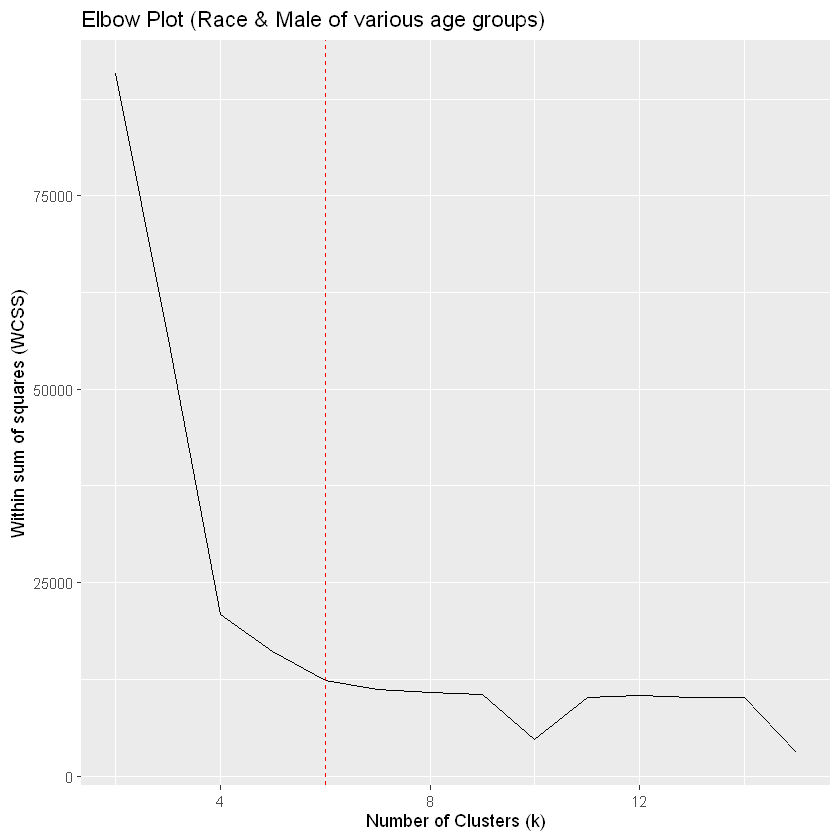

In [260]:
# use the same range of K 
#set.seed(1234)

#Calculate within-cluster sum of squares for number of clusters
WCSS_race_male <- sapply(ks_race_male, FUN = function(k) {
  kmeans(d_race_male <- dist(dataset_plus_census_scaled_race_male), centers = k, nstart = 10)$tot.withinss
  })

# Plot 
ggplot(tibble(ks_race_male, WCSS_race_male), aes(ks_race_male, WCSS_race_male)) + 
  geom_line() +
  geom_vline(xintercept = 6, color = "red", linetype = 2)+
  ggtitle("Elbow Plot (Race & Male of various age groups)") +
  xlab("Number of Clusters (k)") +
  ylab("Within sum of squares (WCSS)")

However, the elbow method says taht 6 clusters is good number of clusters.

### Gap Statistic

Clustering Gap statistic ["clusGap"] from call:
clusGap(x = dataset_plus_census_scaled_race_male, FUNcluster = kmeans, K.max = 10, nstart = 10)
B=100 simulated reference sets, k = 1..10; spaceH0="scaledPCA"
 --> Number of clusters (method 'firstSEmax', SE.factor=1): 9
          logW   E.logW      gap     SE.sim
 [1,] 4.848229 6.383530 1.535301 0.01902188
 [2,] 4.511873 6.134240 1.622368 0.01680852
 [3,] 4.327225 6.014977 1.687752 0.01586448
 [4,] 4.195554 5.915407 1.719853 0.01489045
 [5,] 4.066405 5.850163 1.783759 0.01380141
 [6,] 4.002059 5.798475 1.796416 0.01423955
 [7,] 3.937818 5.756973 1.819155 0.01421749
 [8,] 3.846232 5.719287 1.873056 0.01455619
 [9,] 3.796128 5.685850 1.889722 0.01435162
[10,] 3.761858 5.654189 1.892331 0.01444457

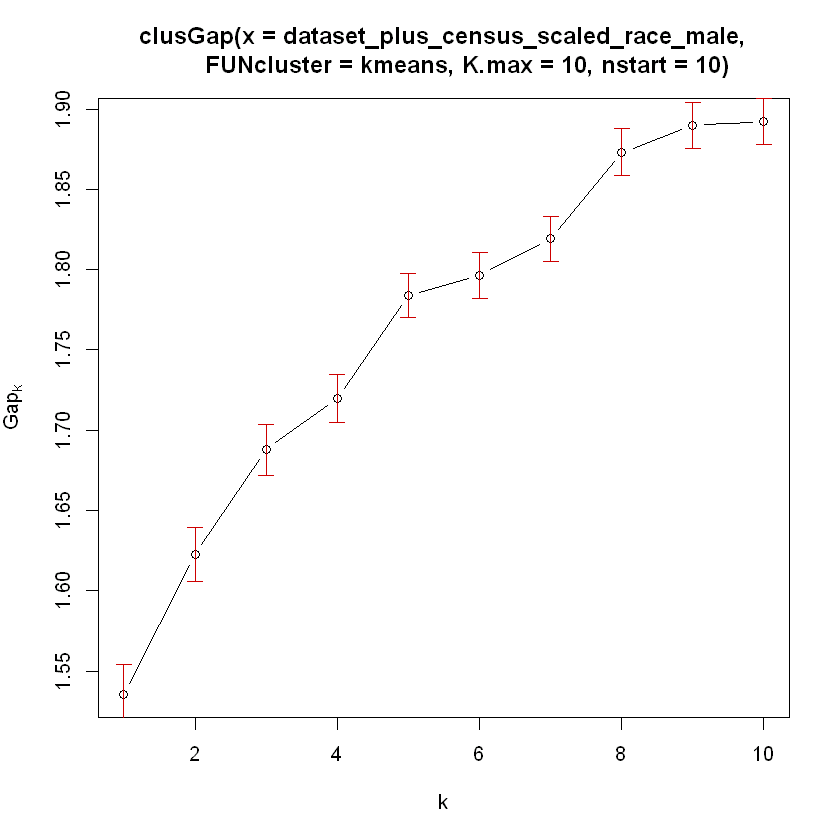

In [261]:
k_gap_race_male <- clusGap(dataset_plus_census_scaled_race_male, 
             FUN = kmeans,  
             nstart = 10, 
             K.max = 10)
k_gap_race_male

plot(k_gap_race_male)

Based on the gap statistic, we see that 2 clusters could be enough for the clusters.

### Clustering Tendency (Hopkins Statistic)

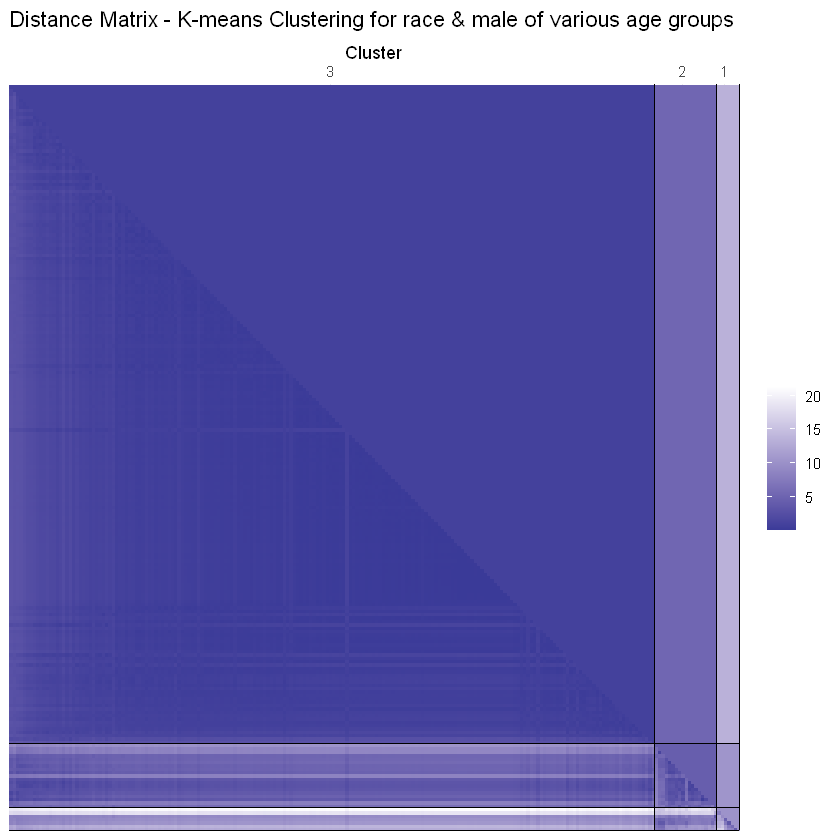

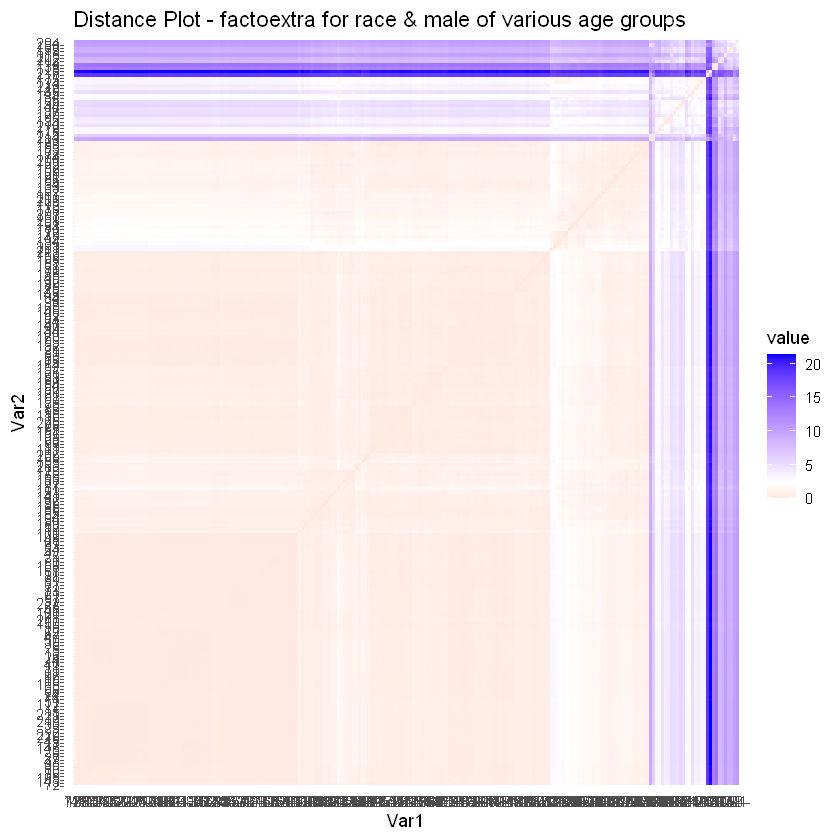

In [276]:
# K-means clustering using specific number of clusters
k_means_race_male_new <- kmeans(dataset_plus_census_scaled_race_male, centers=3, nstart = 10)

# distance for incomes
d_race_male_new <- dist(dataset_plus_census_scaled_race_male)

# Create ggdissplot
diss_plot_race_male <- ggdissplot(d_race_male_new, labels = k_means_race_male_new$cluster) +
  ggtitle("Distance Matrix - K-means Clustering for race & male of various age groups") +
  theme_minimal()

# Create factoextra plot
fviz_plot_race_male <- fviz_dist(d_race_male_new) +
  ggtitle("Distance Plot - factoextra for race & male of various age groups") +
  theme_minimal()

diss_plot_race_male
fviz_plot_race_male

Looks like we just need 3 clusters for the dataset.

### Compare clusterings (unsupervised)

In [278]:
# k-means clustering with different numbers of clusters
k_means_race_male_first <- kmeans(dataset_plus_census_scaled_race_male, centers = 2)
k_means_race_male_second <- kmeans(dataset_plus_census_scaled_race_male, centers = 4)
k_means_race_male_third <- kmeans(dataset_plus_census_scaled_race_male, centers = 6)
k_means_race_male_fourth <- kmeans(dataset_plus_census_scaled_race_male, centers = 8)

# Compute clustering statistics for each clustering result
cluster_stats <- sapply(
  list(
    km_first = k_means_race_male_first$cluster,
    km_second = k_means_race_male_second$cluster,
    km_third = k_means_race_male_third$cluster,
    km_fourth = k_means_race_male_fourth$cluster
  ),
  FUN = function(x) fpc::cluster.stats(d_race_male, x)
)

# Extract the desired statistics
race_male_cluster_stats <- cluster_stats[c("within.cluster.ss", "avg.silwidth", "pearsongamma", "dunn"), ]

# Print the results
print(race_male_cluster_stats)

                  km_first  km_second  km_third   km_fourth
within.cluster.ss 906.5738  409.1347   294.5293   261.5026 
avg.silwidth      0.8410627 0.733848   0.582773   0.4981945
pearsongamma      0.8481538 0.7515262  0.6085253  0.5156731
dunn              0.2212745 0.07297101 0.04306338 0.0236391


Looking at the sum of squares, we see that the value starts to decrease not so sifnificantly after 6 clusters. 
Looking at the average silwidth values, we can see that it's max at two (but 3 is reasonable too) clusters.
The pearson gamma values also indicate that we just need two clusters (3 is reasonable too) for this dataset since this value is highest for clusters. This values does not improve much (does not decrease) with more clusters added.  
The dunn index also indicates that we need 2 clusters for this dataset since it has the highest value for 2 clusters. The value does not improve (does not decrease) with  more clusters added. 
Overall, these values indicate that adding more clusters might lead to more compact clusters but less defined and well-separated clusters. Therefore, 2 clusters could offer the most robust clustering for the dataset.

### Inspect the clusters (Visualization)

Too few points to calculate an ellipse
Too few points to calculate an ellipse


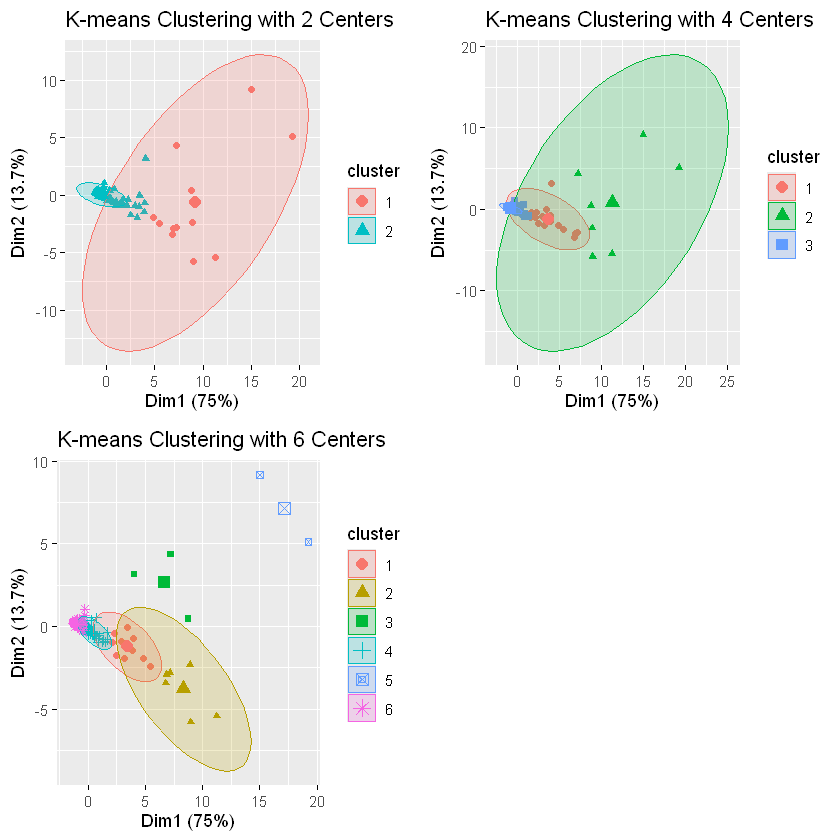

In [280]:
# K-means clustering with 2 clusters
kmeans_race_male_first <- kmeans(dataset_plus_census_scaled_race_male, centers = 2)
plot_kmeans_race_male_first <- fviz_cluster(kmeans_race_male_first, data = dataset_plus_census_scaled_race_male,
                              centroids = TRUE, geom = "point", ellipse.type = "norm") +
  labs(title = "K-means Clustering with 2 Centers")

# K-means clustering with 3 clusters
kmeans_race_male_second <- kmeans(dataset_plus_census_scaled_race_male, centers = 3)
plot_kmeans_race_male_second <- fviz_cluster(kmeans_race_male_second, data = dataset_plus_census_scaled_race_male,
                              centroids = TRUE, geom = "point", ellipse.type = "norm") +
  labs(title = "K-means Clustering with 4 Centers")

# K-means clustering with 6 clusters
kmeans_race_male_third <- kmeans(dataset_plus_census_scaled_race_male, centers = 6)
plot_kmeans_race_male_third <- fviz_cluster(kmeans_race_male_third, data = dataset_plus_census_scaled_race_male,
                              centroids = TRUE, geom = "point", ellipse.type = "norm") +
  labs(title = "K-means Clustering with 6 Centers")

# Arrange the plots side by side in a 2x2 grid
combined_plot_race_male <- ggarrange(plot_kmeans_race_male_first, plot_kmeans_race_male_second, plot_kmeans_race_male_third, ncol = 2, nrow = 2)

# Display the combined plot
print(combined_plot_race_male)

#Save the plot
ggsave("combined_plot_race_male.png", plot = combined_plot_race_male, width = 6, height = 3)

We can see that the datapoints on cluster 3 might be part of cluster 1. So we might be good with only 2 clusters for the dataset.

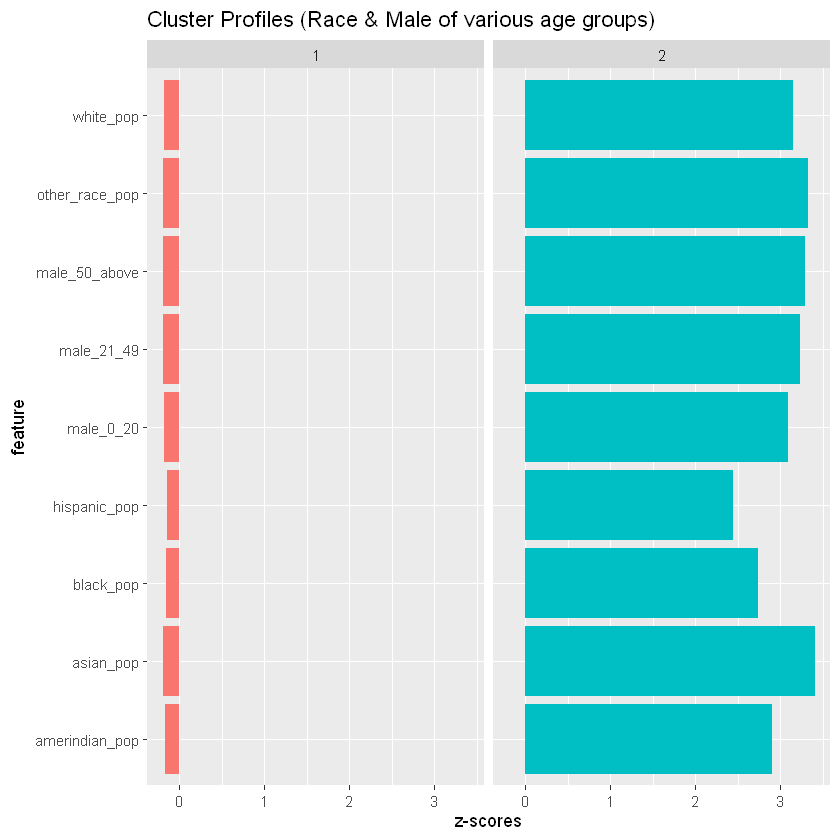

In [286]:
# Adjust the k value for further inspection of the clusters
k_means_race_male <- kmeans(dataset_plus_census_scaled_race_male, centers=2, nstart = 10)

cluster_profile_race_male <- ggplot(pivot_longer(as_tibble(k_means_race_male$centers,  rownames = "cluster"), 
  cols = colnames(k_means_race_male$centers)), 
  aes(y = name, x = value, fill = cluster)) +
  geom_bar(stat = "identity") +
  facet_grid(cols = vars(cluster)) +
  labs(y = "feature", x = "z-scores", title = "Cluster Profiles (Race & Male of various age groups)") + 
  guides(fill="none")

#Save teh profile
ggsave("cluster_profile_race_male.png", plot = cluster_profile_race_male, width = 6, height = 2)

cluster_profile_race_male

When 3 clusters were used, the third cluster had all the distributions for all features nearly similar which is not a good to provide variability details on the dataset. Using only 2 clusters, majority of the variation of the dataset was properly defined between the clusters. This indicates that we might need only 2 clusters for the dataset.

In [287]:
k_means_race_male

K-means clustering with 2 clusters of sizes 210, 12

Cluster means:
  white_pop  black_pop  asian_pop hispanic_pop amerindian_pop other_race_pop
1 -0.180225 -0.1563314 -0.1948347   -0.1396746     -0.1659351     -0.1898007
2  3.153938  2.7358002  3.4096072    2.4443049      2.9038648      3.3215128
   male_0_20 male_21_49 male_50_above
1 -0.1764374 -0.1845332    -0.1883752
2  3.0876543  3.2293313     3.2965652

Clustering vector:
  [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [75] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[112] 1 2 2 1 1 2 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1
[149] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1
[186] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1

Within cluster sum of squares by cluster:
[1] 350.7643 555.8095
 (between_SS / total_S

The ratio of between_SS to total_SS is about 54%, suggesting that the clustering structure explains a significant portion of the variability in the data.
Given that the first cluster has distinctly different characteristics compared to the second and that we see a clear separation in terms of average feature values, it is reasonable to conclude that two clusters are sufficient to define the dataset.

### Heat map

In [293]:
# load the dataset
dataset_race_male_heatmap <- read.csv("https://raw.githubusercontent.com/yamphurai/Project2_ClusterAnalysis/refs/heads/main/updated_COVID-19_cases_plus_census.csv")

dataset_race_male_heatmap <- dataset_race_male_heatmap %>% mutate(across(where(is.character), factor))

# Filter by Texas
dataset_race_male_heatmap <- dataset_race_male_heatmap %>% filter(state == "TX")

# filter the dataset
dataset_race_male_heatmap <- dataset_race_male_heatmap %>%
  filter(!(county_name %in% counties_to_exclude))

# select the features
dataset_race_male_heatmap <- dataset_race_male_heatmap %>%  
  select(county_name, confirmed_cases, deaths, total_pop, white_pop, black_pop, asian_pop, hispanic_pop, amerindian_pop, other_race_pop, male_0_20, male_21_49, male_50_above)

# per 1000
dataset_race_male_heatmap <- dataset_race_male_heatmap %>% mutate(
  cases_per_1000 = confirmed_cases/total_pop*1000, 
  deaths_per_1000 = deaths/total_pop*1000, 
  death_per_case = deaths/confirmed_cases)

In [294]:
# remove County from the names and convert them to lowercase
dataset_race_male_heatmap <- dataset_race_male_heatmap %>% mutate(county = county_name %>% 
    str_to_lower() %>% str_replace('\\s+county\\s*$', ''))

# Database join
counties_polygon_TX <- right_join(counties_polygon_TX, dataset_race_male_heatmap)

Joining with `by = join_by(county)`


In [296]:
# Scaling
dataset_race_male_heatmap_scaled <- dataset_race_male_heatmap %>% 
  select( white_pop, black_pop, asian_pop, hispanic_pop, amerindian_pop, other_race_pop, male_0_20, male_21_49, male_50_above) %>% 
  scale() %>% as_tibble()

# k means setting
km_race_male_heatmap <- kmeans(dataset_race_male_heatmap_scaled, centers = 2, nstart = 10)

In [297]:
# Add the cluster labels to the dataset
dataset_plus_census_race_male_clust_heatmap <- dataset_race_male_heatmap %>% 
    add_column(cluster = factor(km_race_male_heatmap$cluster))

In [298]:
# Database join
counties_polygon_TX_race_male_clust <- right_join(counties_polygon_TX, dataset_plus_census_race_male_clust_heatmap, 
                                        join_by(county))

In [299]:
#Final check of number of counties before plotting the heat map
length(unique(counties_polygon_TX_race_male_clust$county))

[1] 222

 [1] "bell"      "brazos"    "cameron"   "el paso"   "grayson"   "hidalgo"  
 [7] "jefferson" "lubbock"   "mclennan"  "nueces"    "smith"     "wichita"  


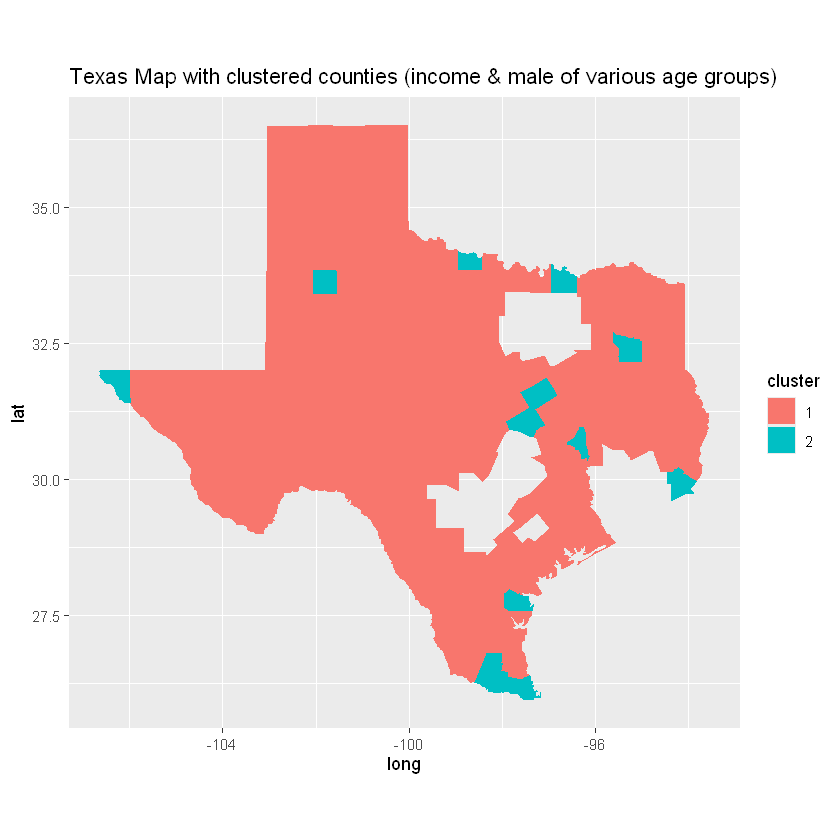

In [300]:
# heat map
ggplot(counties_polygon_TX_race_male_clust, aes(long, lat)) + 
  geom_polygon(aes(group = group, fill = cluster)) +
  coord_quickmap() + 
  labs(title = "Texas Map with clustered counties (income & male of various age groups)")

# Filter for counties in cluster 2
counties_cluster_2 <- counties_polygon_TX_race_male_clust %>%
  filter(cluster == 2)

# Print the counties in cluster 2
print(unique(counties_cluster_2$county))

## K-means (Euclidean distance) for variables related to female age ranges + Race

In [301]:
# Prepare the dataset
dataset_plus_census_race_female <- dataset_plus_census %>% 
  select(white_pop, black_pop, asian_pop, hispanic_pop, amerindian_pop, other_race_pop, female_0_20, female_21_49, female_50_above) %>% 
  scale() %>% as_tibble()

# Scale the columns for K-means
dataset_plus_census_scaled_race_female <- scale(dataset_plus_census_race_female)

In [303]:
head(dataset_plus_census_race_female)

white_pop,black_pop,asian_pop,hispanic_pop,amerindian_pop,other_race_pop,female_0_20,female_21_49,female_50_above
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.5419058,-0.3645185,-0.3313628,-0.2177805,-0.4551422,-0.4387658,-0.3327554,-0.3491287,-0.4332495
-0.6169804,-0.3607502,-0.3313628,-0.2479489,-0.4779130,-0.4387658,-0.3762362,-0.3982314,-0.4768643
-0.6059778,-0.3564278,-0.3313628,-0.2294297,-0.4551422,-0.4387658,-0.3588796,-0.3760021,-0.4611811
-0.6004244,-0.3610827,-0.3313628,-0.2181961,-0.4779130,-0.4387658,-0.3490980,-0.3695316,-0.4488679
-0.4684278,-0.3471179,-0.3313628,-0.2177546,-0.4741178,2.3858128,-0.3295942,-0.3344657,-0.3745347
-0.5848750,-0.3640752,-0.3313628,-0.2339102,-0.4513470,-0.4387658,-0.3601918,-0.3739670,-0.4607275


In [305]:
summary(dataset_plus_census_race_female)

   white_pop           black_pop          asian_pop        hispanic_pop    
 Min.   :-0.642387   Min.   :-0.36496   Min.   :-0.3314   Min.   :-0.2510  
 1st Qu.:-0.554748   1st Qu.:-0.35884   1st Qu.:-0.3278   1st Qu.:-0.2321  
 Median :-0.379400   Median :-0.31149   Median :-0.3046   Median :-0.2031  
 Mean   : 0.000000   Mean   : 0.00000   Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.:-0.003394   3rd Qu.:-0.06871   3rd Qu.:-0.1875   3rd Qu.:-0.1235  
 Max.   : 4.994073   Max.   : 9.15558   Max.   : 7.3199   Max.   : 9.7590  
 amerindian_pop     other_race_pop      female_0_20        female_21_49     
 Min.   :-0.47791   Min.   :-0.43877   Min.   :-0.38369   Min.   :-0.40366  
 1st Qu.:-0.45894   1st Qu.:-0.43877   1st Qu.:-0.33792   1st Qu.:-0.35719  
 Median :-0.36216   Median :-0.43877   Median :-0.27177   Median :-0.29011  
 Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.00000  
 3rd Qu.:-0.04717   3rd Qu.:-0.06472   3rd Qu.:-0.09861   3rd Qu.:-0.09495  
 Max. 

### Clustering Tendency (Hopkins Statistic)

In [306]:
# Compute the Hopkins statistic
set.seed(123) 
hopkins_stat_race_female<- hopkins(dataset_plus_census_race_female)
hopkins_stat_race_female

[1] 1

### Average Silhouette Width

Warning message:
"did not converge in 10 iterations"
Warning message:
"did not converge in 10 iterations"


[1] 2


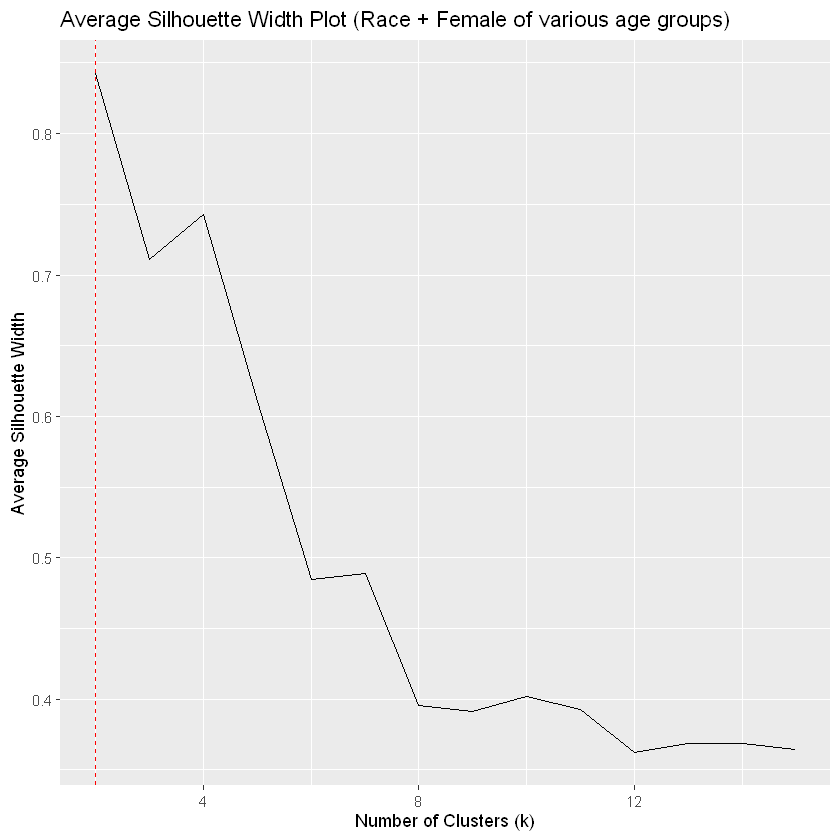

In [307]:
# range for number of clusters
ks_race_female <- 2:15

# distance
d_race_female <- dist(dataset_plus_census_race_female)

# Average Silhouette Width
ASW_race_female <- sapply(ks_race_female, FUN=function(k) {
  kmeans_result <- kmeans(dataset_plus_census_race_female, centers = k, nstart = 10)
  silhouette_info <- silhouette(kmeans_result$cluster, d_race_female)
  mean(silhouette_info[, 3])  # Return the average silhouette width
})

# best k
best_k_race_female <- ks_race_female[which.max(ASW_race_female)]
print(best_k_race_female)

# Plot the Average Silhouette Width
ggplot(data.frame(ks_race_female, ASW_race_female), aes(x = ks_race_female, y = ASW_race_female)) + 
  geom_line() +
  geom_vline(xintercept = best_k_race_female, color = "red", linetype = 2) + 
  ggtitle("Average Silhouette Width Plot (Race + Female of various age groups)") +
  xlab("Number of Clusters (k)") +
  ylab("Average Silhouette Width")

  cluster size ave.sil.width
1       1  210          0.88
2       2   12          0.15
  cluster size ave.sil.width
1       1    2          0.45
2       2   18          0.12
3       3  195          0.82
4       4    7          0.23
  cluster size ave.sil.width
1       1   59          0.03
2       2   10          0.12
3       3   20          0.11
4       4    2          0.04
5       5    2          0.33
6       6  120          0.67
7       7    3          0.18
8       8    6          0.17


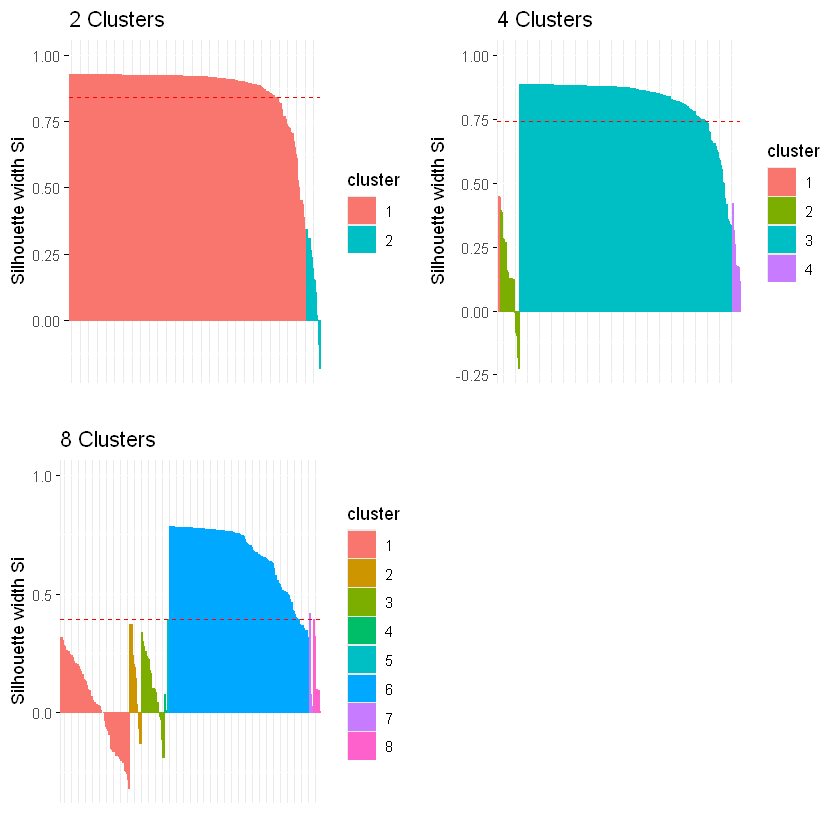

In [308]:
# K-means clustering (10 random restarts)
k_means_race_female_first <- kmeans(dataset_plus_census_race_female, centers=2, nstart = 10)
k_means_race_female_second <- kmeans(dataset_plus_census_race_female, centers=4, nstart = 10)
k_means_race_female_third <- kmeans(dataset_plus_census_race_female, centers=8, nstart = 10)

# Compute silhouette scores
sil_race_female_first <- silhouette(k_means_race_female_first$cluster, d_race_female)
sil_race_female_second <- silhouette(k_means_race_female_second$cluster, d_race_female)
sil_race_female_third <- silhouette(k_means_race_female_third$cluster, d_race_female)

# Arrange the plots side by side in a 2x2 grid
sil_race_female_first <- silhouette(k_means_race_female_first$cluster, d_race_female)
sil_race_female_second <- silhouette(k_means_race_female_second$cluster, d_race_female)
sil_race_female_third <- silhouette(k_means_race_female_third$cluster, d_race_female)

# Visualize silhouette plots
p1 <- fviz_silhouette(sil_race_female_first) + ggtitle("2 Clusters")
p2 <- fviz_silhouette(sil_race_female_second) + ggtitle("4 Clusters")
p3 <- fviz_silhouette(sil_race_female_third) + ggtitle("8 Clusters")

# Arrange the plots side by side in a 2x2 grid (note the empty space)
combined_silplot_race_female <- ggarrange(p1, p2, p3, ncol = 2, nrow = 2)

# Display the combined plot
print(combined_silplot_race_female)

### Elbow Method: Within-Cluster Sum of Square

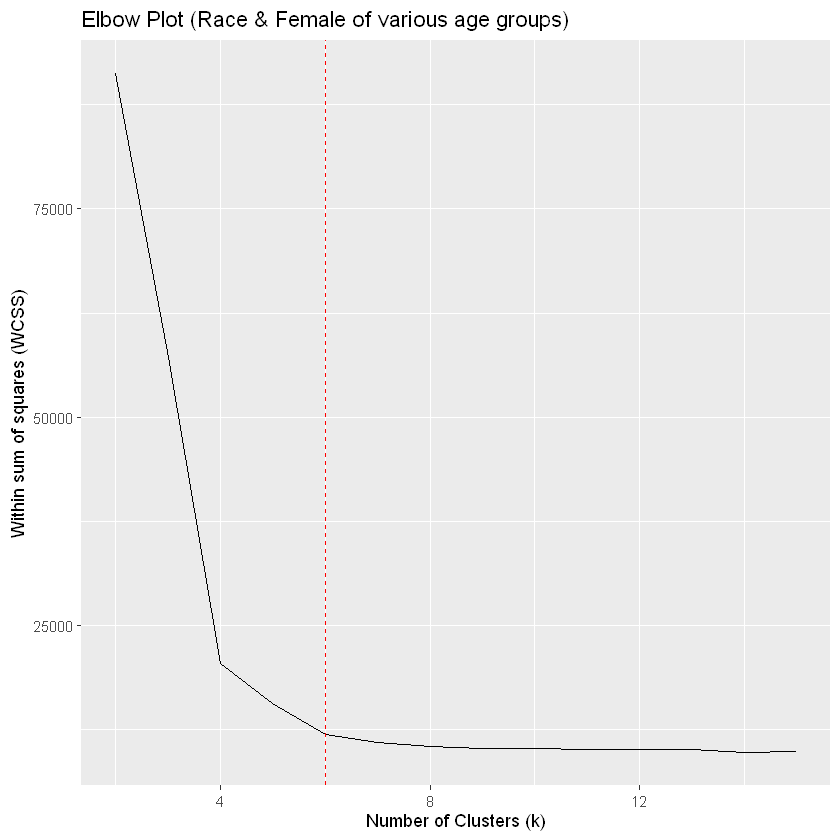

In [313]:
#Calculate within-cluster sum of squares for number of clusters
WCSS_race_female <- sapply(ks_race_female, FUN = function(k) {
  kmeans(d_race_female <- dist(dataset_plus_census_scaled_race_female), centers = k, nstart = 10)$tot.withinss
  })

# Plot 
ggplot(tibble(ks_race_female, WCSS_race_female), aes(ks_race_female, WCSS_race_female)) + 
  geom_line() +
  geom_vline(xintercept = 6, color = "red", linetype = 2)+
  ggtitle("Elbow Plot (Race & Female of various age groups)") +
  xlab("Number of Clusters (k)") +
  ylab("Within sum of squares (WCSS)")

### Gap Statistic

Clustering Gap statistic ["clusGap"] from call:
clusGap(x = dataset_plus_census_scaled_race_female, FUNcluster = kmeans, K.max = 10, nstart = 10)
B=100 simulated reference sets, k = 1..10; spaceH0="scaledPCA"
 --> Number of clusters (method 'firstSEmax', SE.factor=1): 9
          logW   E.logW      gap     SE.sim
 [1,] 4.842631 6.386834 1.544203 0.01792182
 [2,] 4.505148 6.139942 1.634795 0.01790715
 [3,] 4.340818 6.014160 1.673343 0.01577769
 [4,] 4.195651 5.913503 1.717853 0.01613532
 [5,] 4.058177 5.848559 1.790382 0.01458124
 [6,] 3.974908 5.796298 1.821391 0.01286620
 [7,] 3.916163 5.755046 1.838884 0.01344509
 [8,] 3.849193 5.717234 1.868040 0.01333781
 [9,] 3.784229 5.683545 1.899317 0.01363184
[10,] 3.749470 5.652317 1.902848 0.01378871

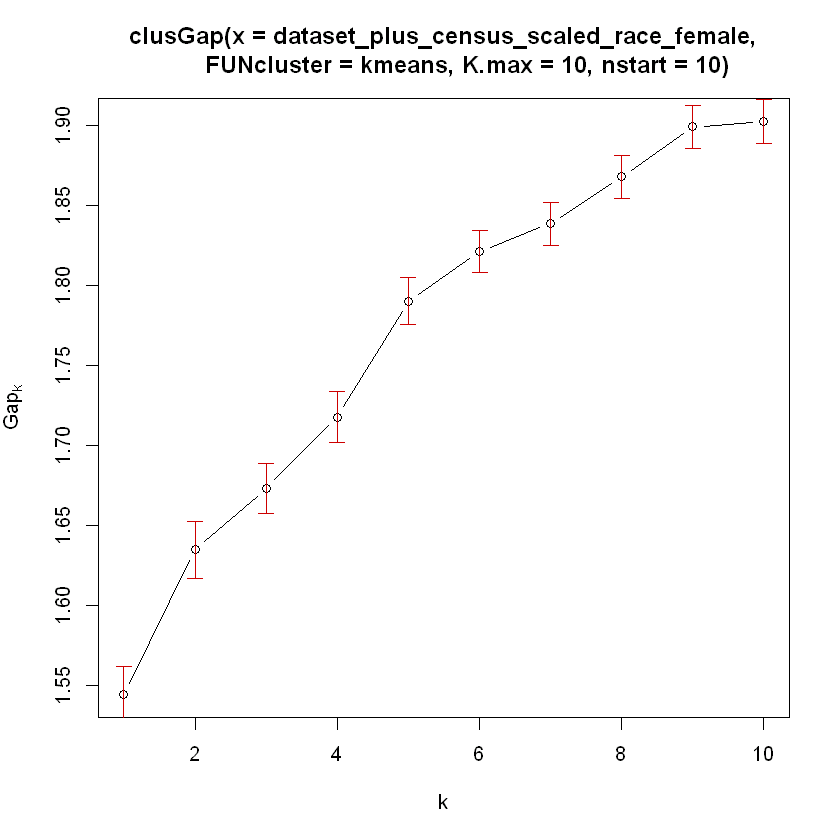

In [314]:
k_gap_race_female <- clusGap(dataset_plus_census_scaled_race_female, 
             FUN = kmeans,  
             nstart = 10, 
             K.max = 10)
k_gap_race_female

plot(k_gap_race_female)

### Clustering Tendency (Hopkins Statistic)

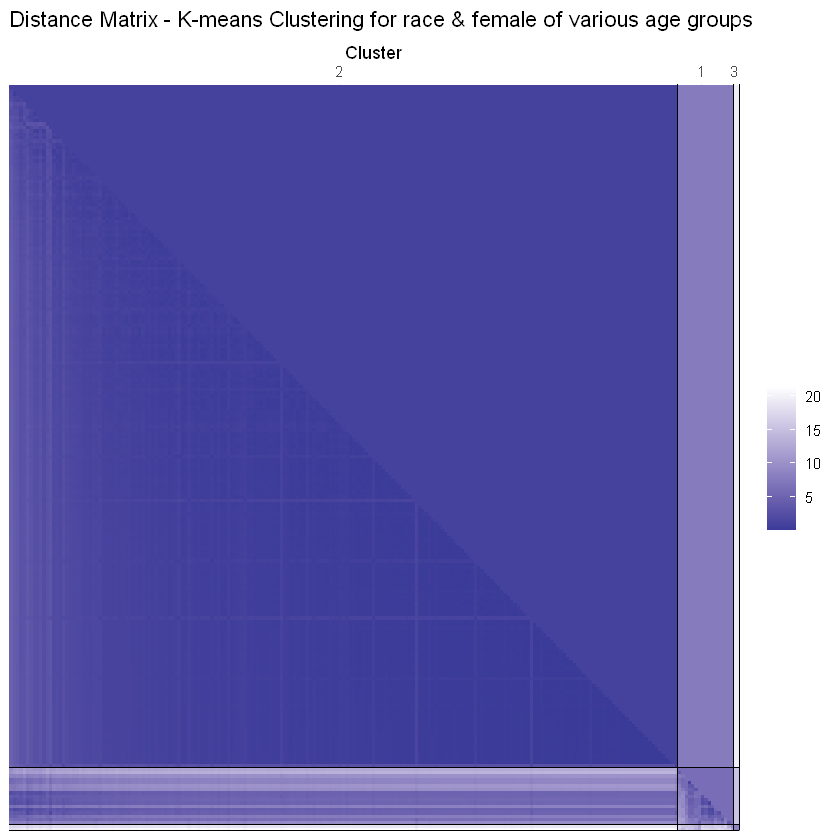

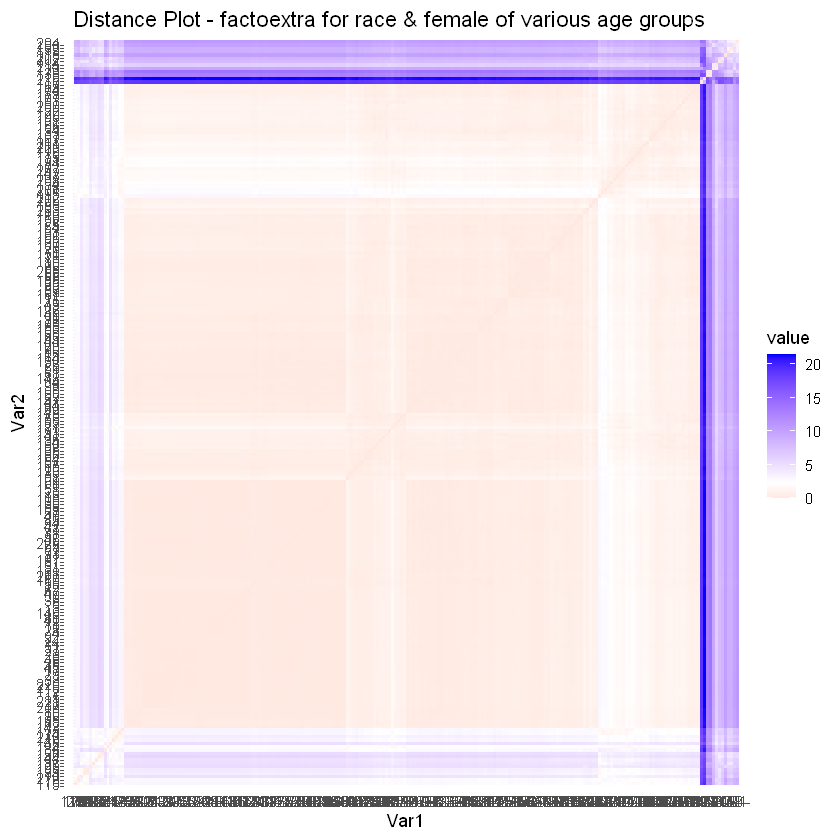

In [315]:
# K-means clustering using specific number of clusters
k_means_race_female_new <- kmeans(dataset_plus_census_scaled_race_female, centers=3, nstart = 10)

# distance for incomes
d_race_female_new <- dist(dataset_plus_census_scaled_race_female)

# Create ggdissplot
diss_plot_race_female <- ggdissplot(d_race_female_new, labels = k_means_race_female_new$cluster) +
  ggtitle("Distance Matrix - K-means Clustering for race & female of various age groups") +
  theme_minimal()

# Create factoextra plot
fviz_plot_race_female <- fviz_dist(d_race_female_new) +
  ggtitle("Distance Plot - factoextra for race & female of various age groups") +
  theme_minimal()

diss_plot_race_female
fviz_plot_race_female

### Compare clusterings (unsupervised)

In [316]:
# k-means clustering with different numbers of clusters
k_means_race_female_first <- kmeans(dataset_plus_census_scaled_race_female, centers = 2)
k_means_race_female_second <- kmeans(dataset_plus_census_scaled_race_female, centers = 4)
k_means_race_female_third <- kmeans(dataset_plus_census_scaled_race_female, centers = 6)
k_means_race_female_fourth <- kmeans(dataset_plus_census_scaled_race_male, centers = 8)

# Compute clustering statistics for each clustering result
cluster_stats <- sapply(
  list(
    km_first = k_means_race_female_first$cluster,
    km_second = k_means_race_female_second$cluster,
    km_third = k_means_race_female_third$cluster,
    km_fourth = k_means_race_female_fourth$cluster
  ),
  FUN = function(x) fpc::cluster.stats(d_race_female, x)
)

# Extract the desired statistics
race_female_cluster_stats <- cluster_stats[c("within.cluster.ss", "avg.silwidth", "pearsongamma", "dunn"), ]

# Print the results
print(race_female_cluster_stats)

                  km_first   km_second km_third   km_fourth 
within.cluster.ss 916.6581   408.3499  320.8259   249.3198  
avg.silwidth      0.8278787  0.7429037 0.4847671  0.3972663 
pearsongamma      0.8304693  0.764777  0.5064265  0.4059028 
dunn              0.09374369 0.1287965 0.02236324 0.01231199


### Inspect the clusters (Visualization)

Too few points to calculate an ellipse
Too few points to calculate an ellipse


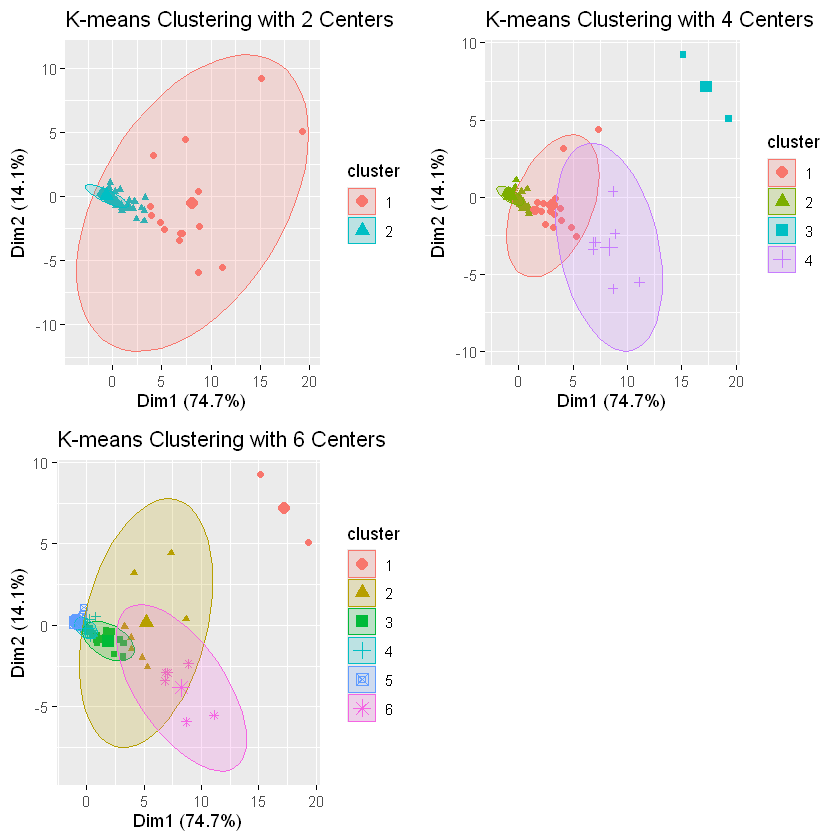

In [317]:
# K-means clustering with 2 clusters
kmeans_race_female_first <- kmeans(dataset_plus_census_scaled_race_female, centers = 2)
plot_kmeans_race_female_first <- fviz_cluster(kmeans_race_female_first, data = dataset_plus_census_scaled_race_female,
                              centroids = TRUE, geom = "point", ellipse.type = "norm") +
  labs(title = "K-means Clustering with 2 Centers")

# K-means clustering with 4 clusters
kmeans_race_female_second <- kmeans(dataset_plus_census_scaled_race_female, centers = 4)
plot_kmeans_race_female_second <- fviz_cluster(kmeans_race_female_second, data = dataset_plus_census_scaled_race_female,
                              centroids = TRUE, geom = "point", ellipse.type = "norm") +
  labs(title = "K-means Clustering with 4 Centers")

# K-means clustering with 6 clusters
kmeans_race_female_third <- kmeans(dataset_plus_census_scaled_race_female, centers = 6)
plot_kmeans_race_female_third <- fviz_cluster(kmeans_race_female_third, data = dataset_plus_census_scaled_race_female,
                              centroids = TRUE, geom = "point", ellipse.type = "norm") +
  labs(title = "K-means Clustering with 6 Centers")

# Arrange the plots side by side in a 2x2 grid
combined_plot_race_female <- ggarrange(plot_kmeans_race_female_first, plot_kmeans_race_female_second, plot_kmeans_race_female_third, ncol = 2, nrow = 2)

# Display the combined plot
print(combined_plot_race_female)

#Save the plot
ggsave("combined_plot_race_female.png", plot = combined_plot_race_female, width = 6, height = 3)

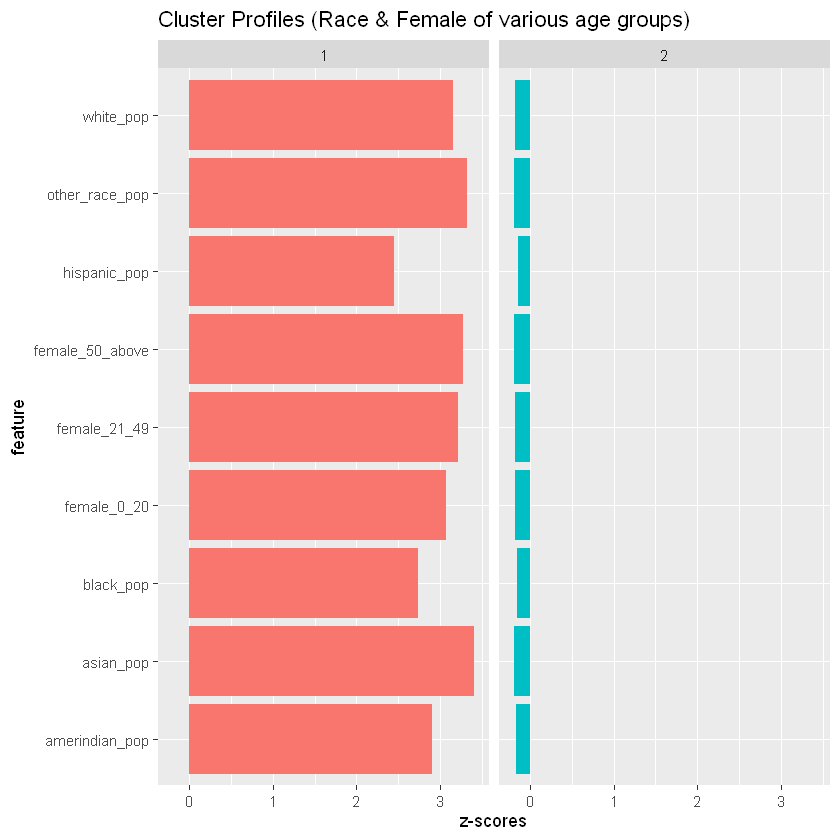

In [321]:
# Adjust the k value for further inspection of the clusters
k_means_race_female <- kmeans(dataset_plus_census_scaled_race_female, centers=2, nstart = 10)

cluster_profile_race_female <- ggplot(pivot_longer(as_tibble(k_means_race_female$centers,  rownames = "cluster"), 
  cols = colnames(k_means_race_female$centers)), 
  aes(y = name, x = value, fill = cluster)) +
  geom_bar(stat = "identity") +
  facet_grid(cols = vars(cluster)) +
  labs(y = "feature", x = "z-scores", title = "Cluster Profiles (Race & Female of various age groups)") + 
  guides(fill="none")

#Save teh profile
ggsave("cluster_profile_race_female.png", plot = cluster_profile_race_female, width = 6, height = 2)

cluster_profile_race_female

In [322]:
k_means_race_female

K-means clustering with 2 clusters of sizes 12, 210

Cluster means:
  white_pop  black_pop  asian_pop hispanic_pop amerindian_pop other_race_pop
1  3.153938  2.7358002  3.4096072    2.4443049      2.9038648      3.3215128
2 -0.180225 -0.1563314 -0.1948347   -0.1396746     -0.1659351     -0.1898007
  female_0_20 female_21_49 female_50_above
1    3.066069    3.2146552        3.271975
2   -0.175204   -0.1836946       -0.186970

Clustering vector:
  [1] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [38] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [75] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[112] 2 1 1 2 2 1 1 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2
[149] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2
[186] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2

Within cluster sum of squares by cluster:
[1] 565.6347 345.8729
 (betwe

### Heat map

In [323]:
# load the dataset
dataset_race_female_heatmap <- read.csv("https://raw.githubusercontent.com/yamphurai/Project2_ClusterAnalysis/refs/heads/main/updated_COVID-19_cases_plus_census.csv")

dataset_race_female_heatmap <- dataset_race_female_heatmap %>% mutate(across(where(is.character), factor))

# Filter by Texas
dataset_race_female_heatmap <- dataset_race_female_heatmap %>% filter(state == "TX")

# filter the dataset
dataset_race_female_heatmap <- dataset_race_female_heatmap %>%
  filter(!(county_name %in% counties_to_exclude))

# select the features
dataset_race_female_heatmap <- dataset_race_female_heatmap %>%  
  select(county_name, confirmed_cases, deaths, total_pop, white_pop, black_pop, asian_pop, hispanic_pop, amerindian_pop, other_race_pop, female_0_20, female_21_49, female_50_above)

# per 1000
dataset_race_female_heatmap <- dataset_race_female_heatmap %>% mutate(
  cases_per_1000 = confirmed_cases/total_pop*1000, 
  deaths_per_1000 = deaths/total_pop*1000, 
  death_per_case = deaths/confirmed_cases)

In [324]:
# remove County from the names and convert them to lowercase
dataset_race_female_heatmap <- dataset_race_female_heatmap %>% mutate(county = county_name %>% 
    str_to_lower() %>% str_replace('\\s+county\\s*$', ''))

# Database join
counties_polygon_TX <- right_join(counties_polygon_TX, dataset_race_female_heatmap)

Joining with `by = join_by(county, county_name, confirmed_cases, deaths, total_pop, white_pop, black_pop, asian_pop,
hispanic_pop, amerindian_pop, other_race_pop, cases_per_1000, deaths_per_1000, death_per_case)`


In [325]:
# Scaling
dataset_race_female_heatmap_scaled <- dataset_race_female_heatmap %>% 
  select( white_pop, black_pop, asian_pop, hispanic_pop, amerindian_pop, other_race_pop, female_0_20, female_21_49, female_50_above) %>% 
  scale() %>% as_tibble()

# k means setting
km_race_female_heatmap <- kmeans(dataset_race_female_heatmap_scaled, centers = 2, nstart = 10)

In [326]:
# Add the cluster labels to the dataset
dataset_plus_census_race_female_clust_heatmap <- dataset_race_female_heatmap %>% 
    add_column(cluster = factor(km_race_female_heatmap$cluster))

In [327]:
# Database join
counties_polygon_TX_race_female_clust <- right_join(counties_polygon_TX, dataset_plus_census_race_female_clust_heatmap, 
                                        join_by(county))

In [328]:
#Final check of number of counties before plotting the heat map
length(unique(counties_polygon_TX_race_female_clust$county))

[1] 222

 [1] "bell"      "brazos"    "cameron"   "el paso"   "grayson"   "hidalgo"  
 [7] "jefferson" "lubbock"   "mclennan"  "nueces"    "smith"     "wichita"  


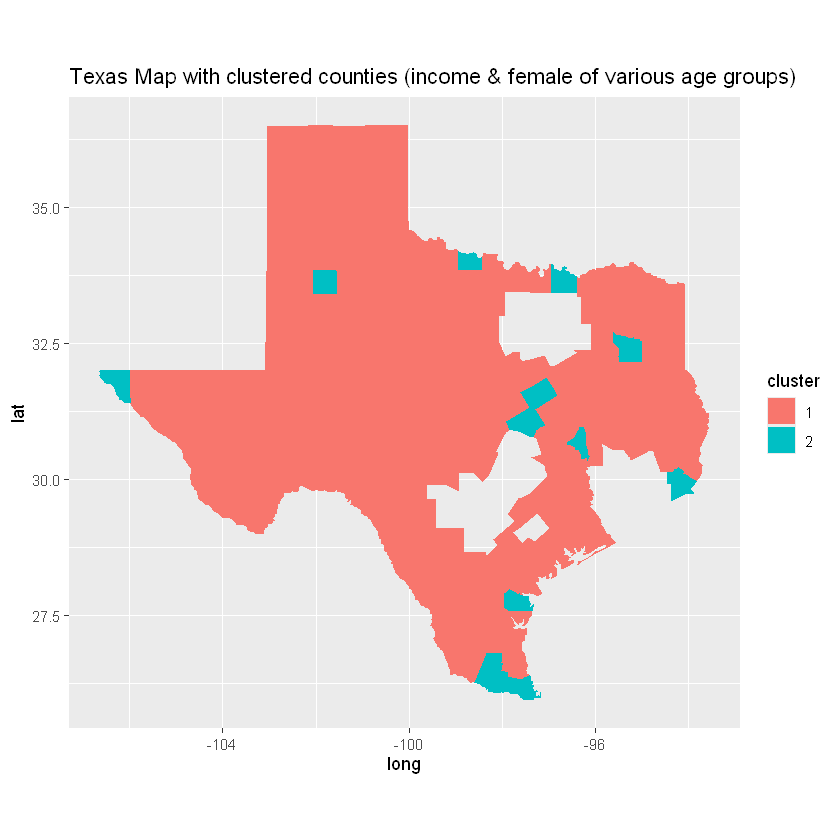

In [329]:
# heat map
ggplot(counties_polygon_TX_race_female_clust, aes(long, lat)) + 
  geom_polygon(aes(group = group, fill = cluster)) +
  coord_quickmap() + 
  labs(title = "Texas Map with clustered counties (income & female of various age groups)")

# Filter for counties in cluster 2
counties_cluster_2 <- counties_polygon_TX_race_female_clust %>%
  filter(cluster == 2)

# Print the counties in cluster 2
print(unique(counties_cluster_2$county))

## K-means (Euclidean distance) for variables related to male age ranges + Income ranges

In [330]:
# Prepare the dataset
dataset_plus_census_income_male <- dataset_plus_census %>% 
  select(income_less_50K, income_50K_100K, income_100K_150K, income_150K_more, male_0_20, male_21_49, male_50_above) %>% 
  scale() %>% as_tibble()

# Scale the columns for K-means
dataset_plus_census_scaled_income_male <- scale(dataset_plus_census_income_male)

In [331]:
head(dataset_plus_census_scaled_income_male)

income_less_50K,income_50K_100K,income_100K_150K,income_150K_more,male_0_20,male_21_49,male_50_above
-0.3755826,-0.4293063,-0.4401619,-0.4148059,-0.3433435,-0.3723423,-0.4551314
-0.4295798,-0.4678877,-0.4769018,-0.4570645,-0.3827586,-0.4213278,-0.5015824
-0.4082498,-0.4543727,-0.4641491,-0.4483214,-0.3575976,-0.4054166,-0.4851651
-0.4047435,-0.4308079,-0.4189074,-0.4492928,-0.3510188,-0.4005129,-0.4686699
-0.3420974,-0.3700479,-0.4043329,-0.4075199,-0.3244151,-0.3565876,-0.3895398
-0.4152040,-0.4430524,-0.4447164,-0.4386068,-0.3648112,-0.3968611,-0.4806523


In [332]:
summary(dataset_plus_census_scaled_income_male)

 income_less_50K    income_50K_100K    income_100K_150K   income_150K_more 
 Min.   :-0.44296   Min.   :-0.48025   Min.   :-0.49239   Min.   :-0.4780  
 1st Qu.:-0.37855   1st Qu.:-0.42067   1st Qu.:-0.43887   1st Qu.:-0.4222  
 Median :-0.28334   Median :-0.31755   Median :-0.34345   Median :-0.3449  
 Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.0000  
 3rd Qu.:-0.06225   3rd Qu.:-0.06348   3rd Qu.:-0.07254   3rd Qu.:-0.1028  
 Max.   : 8.26280   Max.   : 8.07375   Max.   : 7.37936   Max.   : 6.4301  
   male_0_20          male_21_49       male_50_above      
 Min.   :-0.39136   Min.   :-0.42670   Min.   :-0.524613  
 1st Qu.:-0.34323   1st Qu.:-0.37657   1st Qu.:-0.440329  
 Median :-0.27155   Median :-0.29161   Median :-0.306636  
 Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.000000  
 3rd Qu.:-0.08719   3rd Qu.:-0.09854   3rd Qu.:-0.000192  
 Max.   : 9.06421   Max.   : 8.31051   Max.   : 7.969696  

### Clustering Tendency (Hopkins Statistic)

In [333]:
# Compute the Hopkins statistic
set.seed(123) 
hopkins_stat_income_male<- hopkins(dataset_plus_census_scaled_income_male)
hopkins_stat_income_male

[1] 1

### Average Silhouette Width

[1] 2


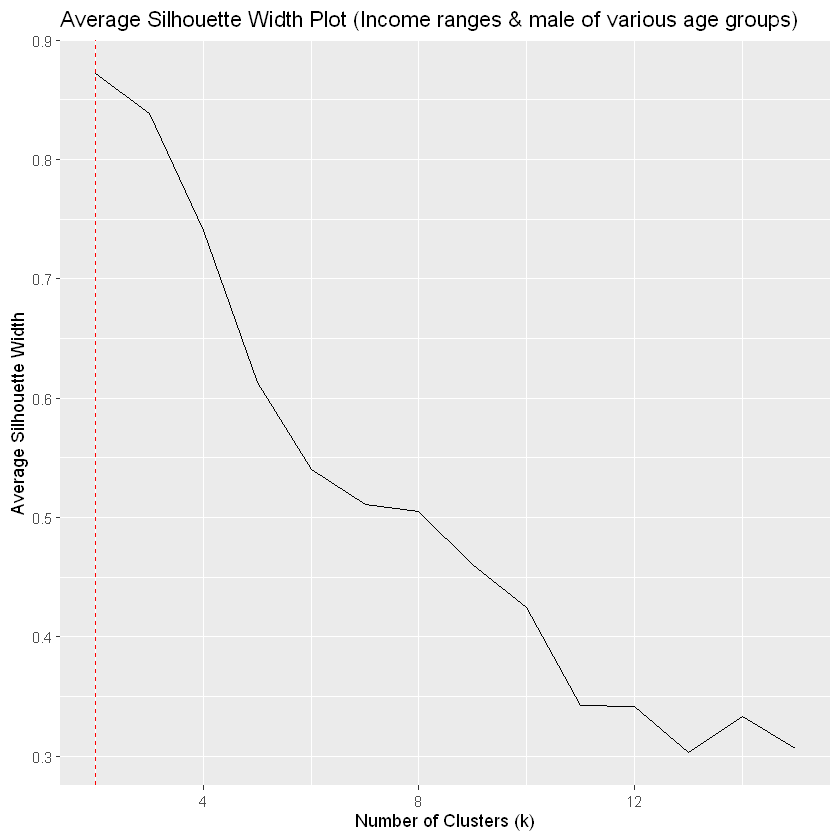

In [334]:
# range for number of clusters
ks_income_male <- 2:15

# distance
d_income_male <- dist(dataset_plus_census_scaled_income_male)

# Average Silhouette Width
ASW_income_male <- sapply(ks_income_male, FUN=function(k) {
  kmeans_result <- kmeans(dataset_plus_census_scaled_income_male, centers = k, nstart = 10)
  silhouette_info <- silhouette(kmeans_result$cluster, d_income_male)
  mean(silhouette_info[, 3])  # Return the average silhouette width
})

# best k
best_k_income_male <- ks_income_male[which.max(ASW_income_male)]
print(best_k_income_male)

# Plot the Average Silhouette Width
ggplot(data.frame(ks_income_male, ASW_income_male), aes(x = ks_income_male, y = ASW_income_male)) + 
  geom_line() +
  geom_vline(xintercept = best_k_income_male, color = "red", linetype = 2) + 
  ggtitle("Average Silhouette Width Plot (Income ranges & male of various age groups)") +
  xlab("Number of Clusters (k)") +
  ylab("Average Silhouette Width")

In [ ]:
# K-means clustering (10 random restarts)
k_means_income_male_first <- kmeans(dataset_plus_census_scaled_income_male, centers=2, nstart = 10)
k_means_income_male_second <- kmeans(dataset_plus_census_scaled_income_male, centers=3, nstart = 10)
k_means_income_male_third <- kmeans(dataset_plus_census_scaled_income_male, centers=5, nstart = 10)

# Compute silhouette scores
sil_income_male_first <- silhouette(k_means_income_male_first$cluster, d_income_male)
sil_income_male_second <- silhouette(k_means_income_male_second$cluster, d_income_male)
sil_income_male_third <- silhouette(k_means_income_male_third$cluster, d_income_male)


# Visualize silhouette plots
p1 <- fviz_silhouette(sil_income_male_first) + ggtitle("2 Clusters")
p2 <- fviz_silhouette(sil_income_male_second) + ggtitle("3 Clusters")
p3 <- fviz_silhouette(sil_income_male_third) + ggtitle("5 Clusters")

# Arrange the plots side by side in a 2x2 grid (note the empty space)
combined_silplot_income_male <- ggarrange(p1, p2, p3, ncol = 2, nrow = 2)

# Display the combined plot
print(combined_silplot_income_male)

  cluster size ave.sil.width
1       1   12          0.33
2       2  210          0.90
  cluster size ave.sil.width
1       1   17          0.36
2       2  203          0.88
3       3    2          0.77
  cluster size ave.sil.width
1       1   10          0.32
2       2   45          0.40
3       3  151          0.71
4       4    2          0.75
5       5   14          0.42


## Compare clusterings (supervised)

In [179]:
dataset_plus_census <- read.csv("https://raw.githubusercontent.com/yamphurai/Project2_ClusterAnalysis/refs/heads/main/updated_COVID-19_cases_plus_census.csv")
dataset_plus_census <- dataset_plus_census %>% filter(state == "TX")

In [180]:
#Checking the ranges for the incomes
summary(dataset_plus_census$median_income)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  24794   42327   48311   49894   55741   93645 

In [183]:
# Pick median_income feature as the ground truth

# Convert the median incomes into 3 categories (low is <50K, medium is 51-100K, and high 100K above)
dataset_plus_census <- dataset_plus_census %>%
  mutate(income_category = cut(median_income, 
                               breaks = c(0, 50000, 75000, 100000), 
                               labels = c("low", "medium", "high"), 
                               include.lowest = TRUE))

# Extract ground truth labels
ground_truth <- dataset_plus_census$income_category

table(ground_truth)

ground_truth
   low medium   high 
   147     96     11 

In [160]:
# Purity function
purity <- function(cluster, truth, show_table = FALSE) {
  if (length(cluster) != length(truth))
    stop("Cluster vector and ground truth vectors are not of the same length!")
  
  tbl <- table(cluster, truth)
  if(show_table)
    print(tbl)
  
  majority <- apply(tbl, 1, max)
  sum(majority) / length(cluster)
}


# Entropy function
entropy <- function(cluster, truth, show_table = FALSE) {
  if (length(cluster) != length(truth))
    stop("Cluster vector and ground truth vectors are not of the same length!")
  
  # calculate membership probability of cluster to class
  tbl <- table(cluster, truth)
  p <- sweep(tbl, 2, colSums(tbl), "/")
  
  if(show_table)
    print(p)

  # calculate cluster entropy
  e <- -p * log(p, 2)
  e <- rowSums(e, na.rm = TRUE)
  
  # weighted sum over clusters
  w <- table(cluster) / length(cluster)
  sum(w * e)
}


In [102]:
# Pick the best clustering for each dataset and compare them

# set different values of k for the datasets to compare
k_means_race_income <- kmeans(dataset_plus_census_scaled_race_income, centers=2, nstart = 10)


#compute purity metrics
purity_score_race_income <- purity(k_means_race_income$cluster, ground_truth, show_table = TRUE)
purity_score_race_4 <- purity(k_means_race_4$cluster, ground_truth, show_table = TRUE)

# Comparison
compare_race_clusterings <- rbind(
    truth = c(unlist(fpc::cluster.stats(d_race, as.numeric(ground_truth), as.numeric(ground_truth), compareonly = TRUE)),
              purity = purity(as.numeric(ground_truth), as.numeric(ground_truth)), 
              entropy = entropy(as.numeric(ground_truth), as.numeric(ground_truth))
              ),
    
    k_means_race_2 = c(unlist(fpc::cluster.stats(d_race, k_means_race_2$cluster, as.numeric(ground_truth), compareonly = TRUE)),
                     purity = purity(k_means_race_2$cluster, as.numeric(ground_truth)),
                     entropy = entropy(k_means_race_2$cluster, as.numeric(ground_truth))
                ),
  
  k_means_race_4 = c(unlist(fpc::cluster.stats(d_race, k_means_race_4$cluster, as.numeric(ground_truth), compareonly = TRUE)),
                     purity = purity(k_means_race_4$cluster, as.numeric(ground_truth)),
                     entropy = entropy(k_means_race_4$cluster, as.numeric(ground_truth))
                    )
    )
     
# Print the comparison results
print(compare_race_clusterings)

ERROR: Error: object 'dataset_plus_census_scaled_race' not found


In [5]:
# Importing necessary libraries
library("tidyverse")
library("ggplot2")
library("ggrepel")
library("ggcorrplot")
library("DT")
library(ggpubr)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


ERROR: Error in library("ggcorrplot"): there is no package called 'ggcorrplot'
